# American Options Pricing using the Longstaff-Schwartz Algorithm

In this notebook, we are going to illustrate the [Longstaff-Schwartz Algorithm](https://people.math.ethz.ch/~hjfurrer/teaching/LongstaffSchwartzAmericanOptionsLeastSquareMonteCarlo.pdf) to price American options.

In [34]:
import numpy as np
from ipywidgets import interact, IntSlider
from aleatory.processes import GBM
from aleatory.utils.utils import draw_paths

%config InlineBackend.figure_format ='retina'

import matplotlib.pyplot as plt
my_style = "https://raw.githubusercontent.com/quantgirluk/matplotlib-stylesheets/main/quant-pastel-light.mplstyle"
plt.style.use(my_style)
plt.rcParams["figure.figsize"] = (12, 7)
plt.rcParams["figure.dpi"] = 100

## Asset Price Dynamics

We are going to use a Geometric Brownian process to model the dynamics of the price of the underlying asset.
This means that $X$ satisfies the following SDE

$$dX_t = rX_t dt + \sigma X_tdW_t,$$

with $X_0=x_0>0$, where $W_t$ denotes a standard Brownian Motion, and  both $r$ and  $\sigma$ are known parameters.

### Parameters, Maturity, Simulation Specs

- r = 2%
- $\sigma$ = 15%
- $x_0=1.0$
- Maturity T=6 (we can think of this as 6 months from today)
- We will simulate $N=50$ paths over a grid of $n = 120$ points (20 days in each of the 6 months)

In [35]:
r = 0.02
sigma = 0.15
x0 = 1.0
T = 6
N = 50
n = 20*6
gbm = GBM(initial=x0, drift=r, volatility=sigma, T=T)
paths = gbm.simulate(n=n, N=N) # N paths, with n points

### Simulation

Let's take a look at our simulation.

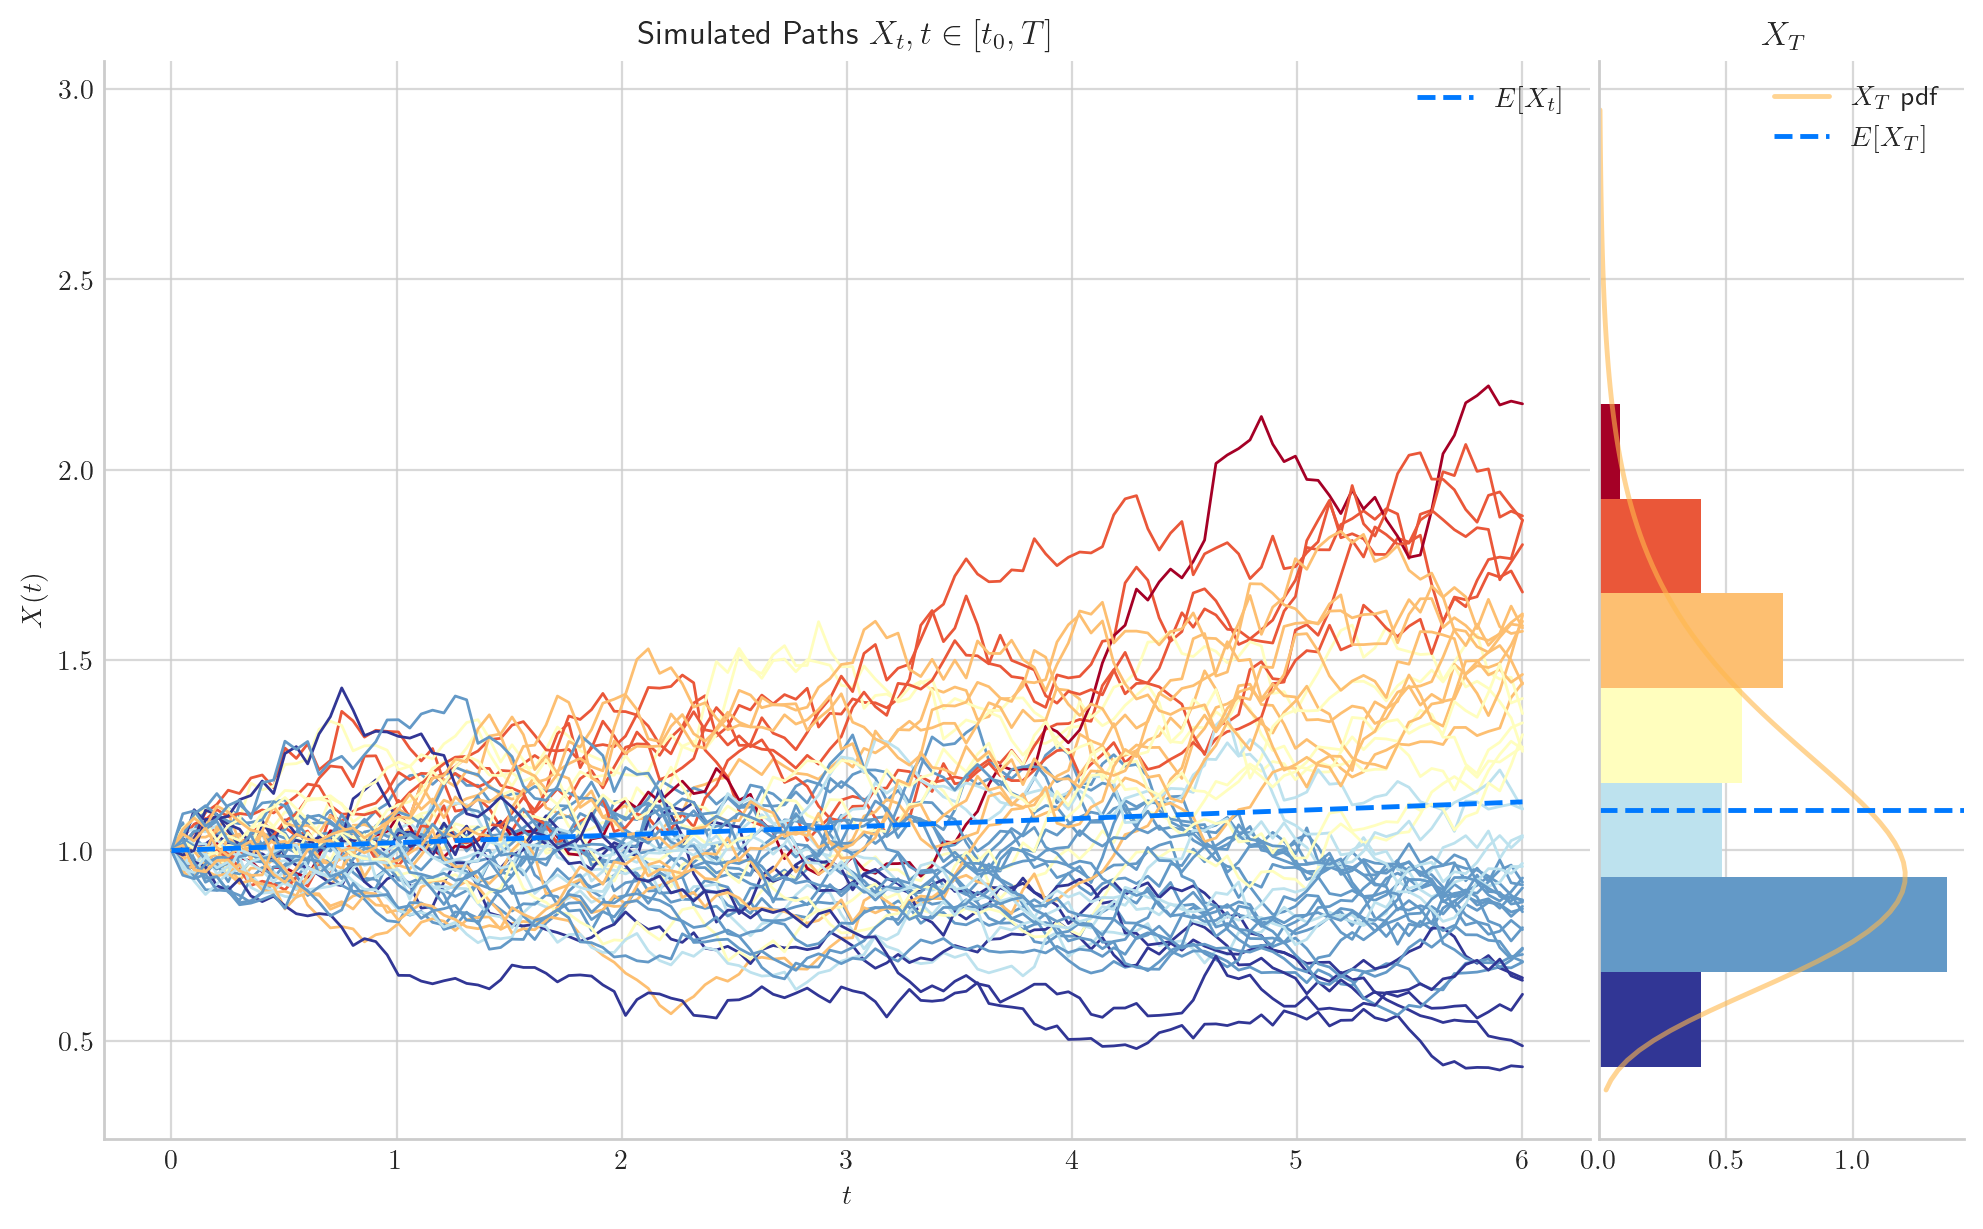

In [36]:
times = gbm.times
expectations = gbm.marginal_expectation(times)
marginalT = gbm.get_marginal(5.0)
X = np.stack(paths, axis=1)
draw_paths(times=times, paths=paths, N=N, expectations=expectations, marginalT=marginalT, marginal=True)
plt.show()

## American Option Contract

- Today the asset price is $x_0 = 1.0$

- We are entering an American (which we approximate via a Bermudan!) Put option contract as the **writer/seller**. 
  
- The **holder/buyer** has the exercise right at any point between today (time $t_0=0$) and maturity $t_n=T=6$.
  
-  If the holder decides to exercises at time $t_i$, this means that  he/she will **sell** the asset (whose market price is $X(t_i)$ at that moment) at price $K=1.1$ to us.

In [37]:
K = 1.1

### What happenes on the grid points?

- If $X(t_i) \geq K$, then the holder has **no** incentive to exercise the option (This would mean selling the asset at price $K$ which makes no sense!) 

- If $X(t_i) < K$, then the option is ITM and the holder **may want to exercise** it. The payoff in case of exercise at time $t_i$ would be

$$Y(t_t) = (K - X(t_i))^+.$$



We can visualise the times when the simulated paths have a positive payoff.

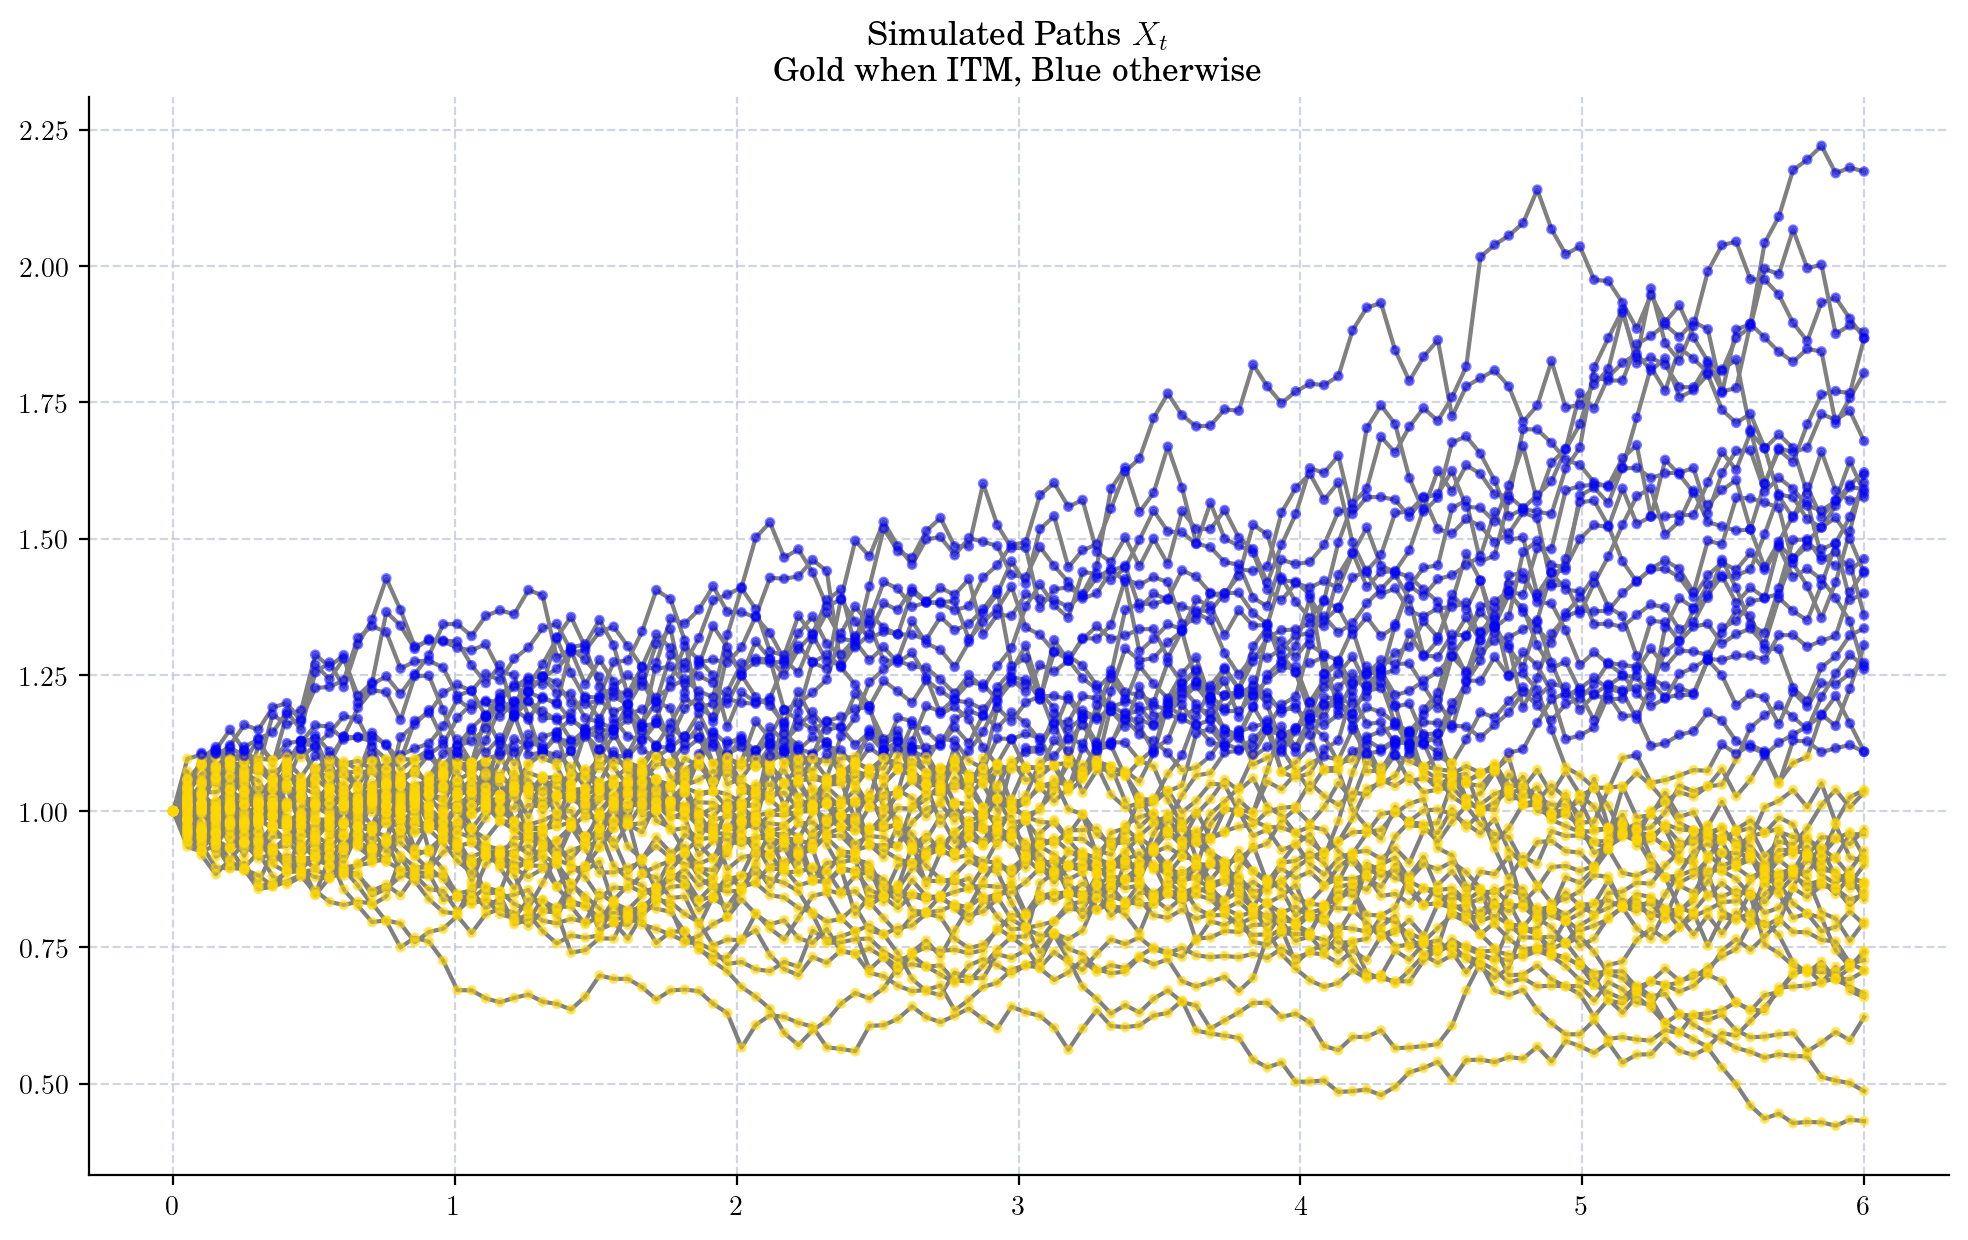

In [38]:
for path in paths:
    colors = ['gold' if (x<K) else 'blue' for x in path]
    plt.plot(times, path, color="gray")
    plt.scatter(times, path, c=colors, s=8, zorder=3, alpha=0.5)
plt.title("Simulated Paths $X_t$\n Gold when ITM, Blue otherwise")
plt.show()

Let's take a look at a couple of paths to have a cleaner picture

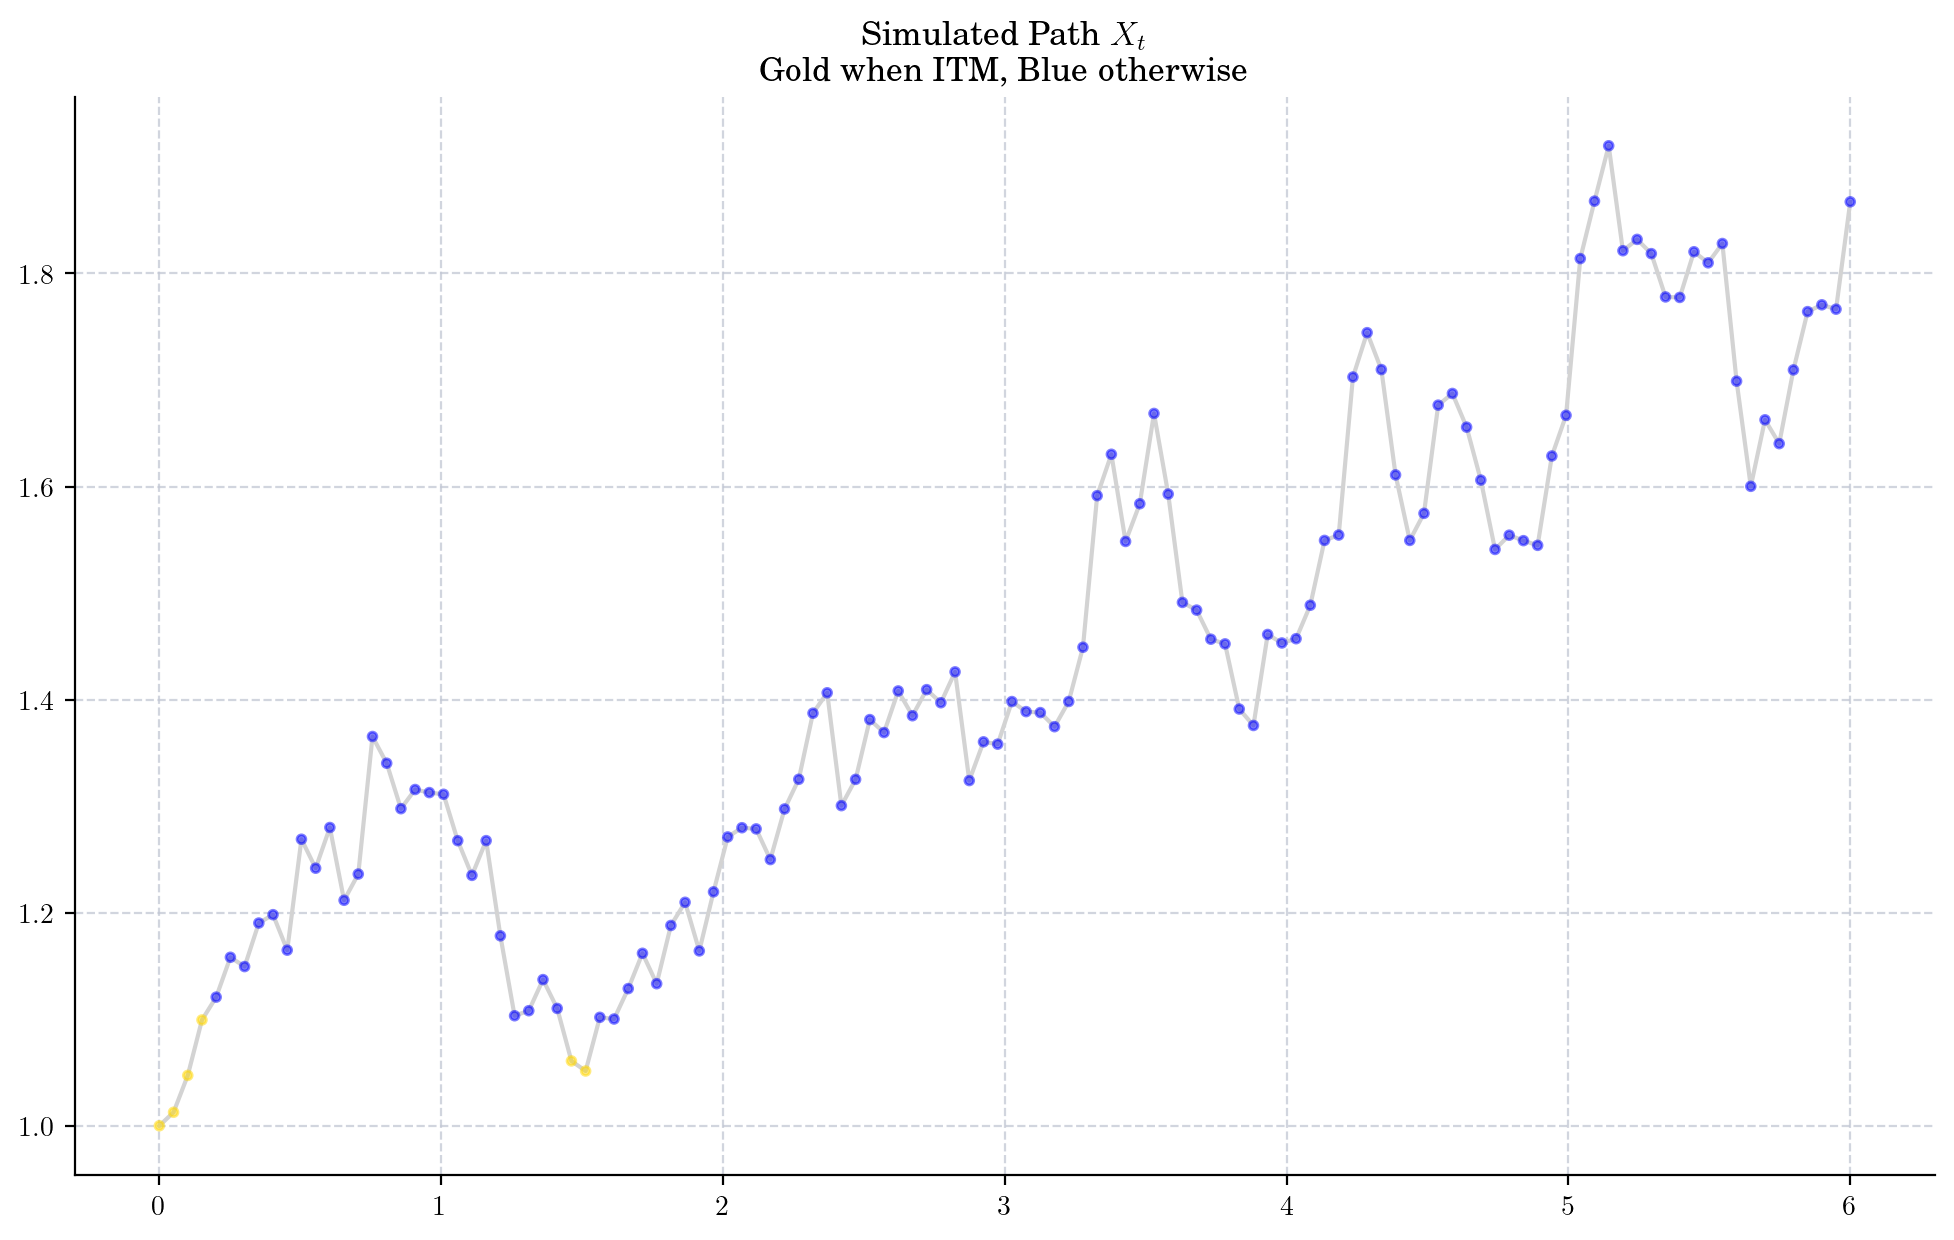

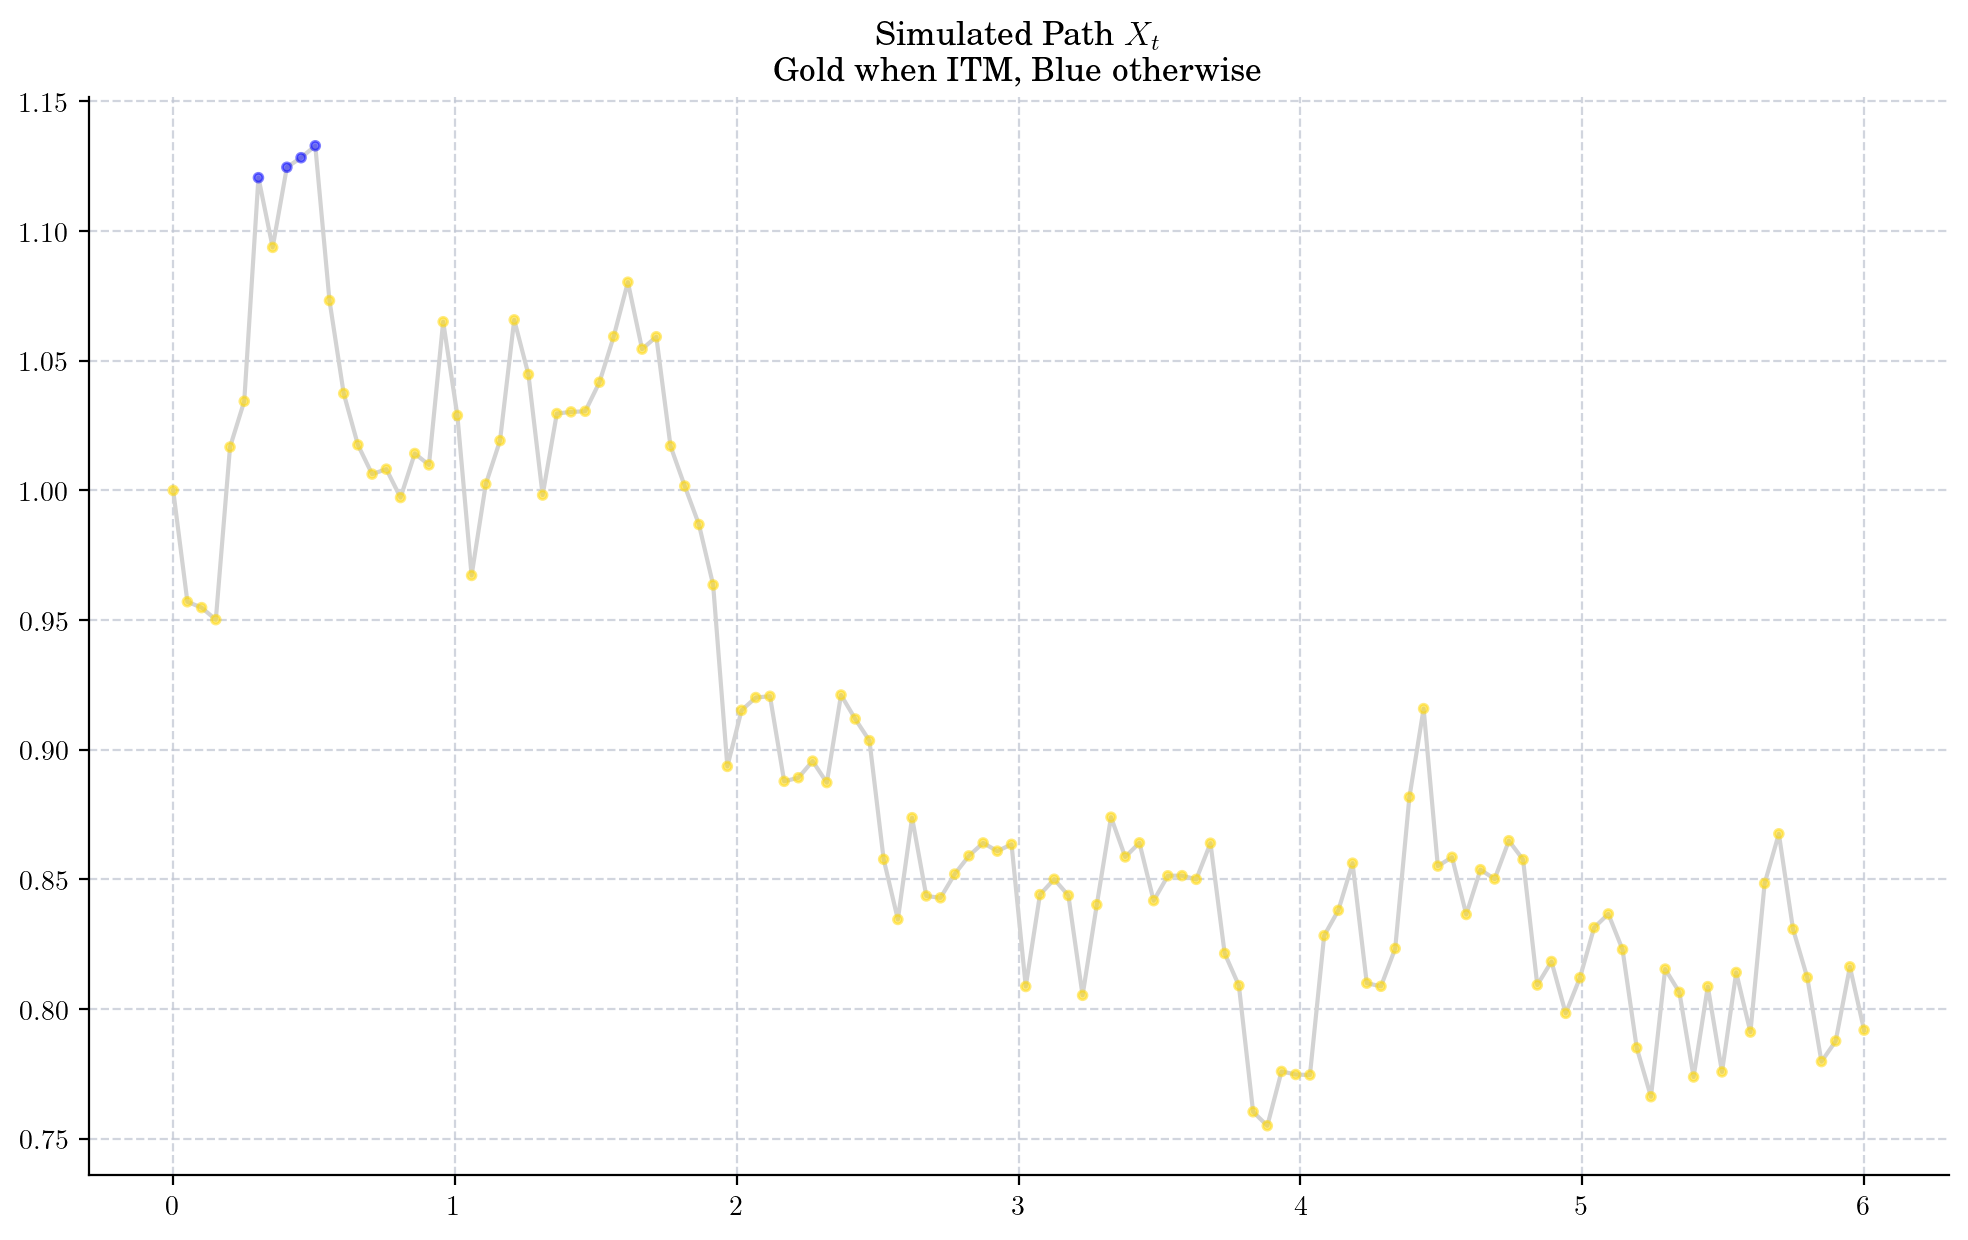

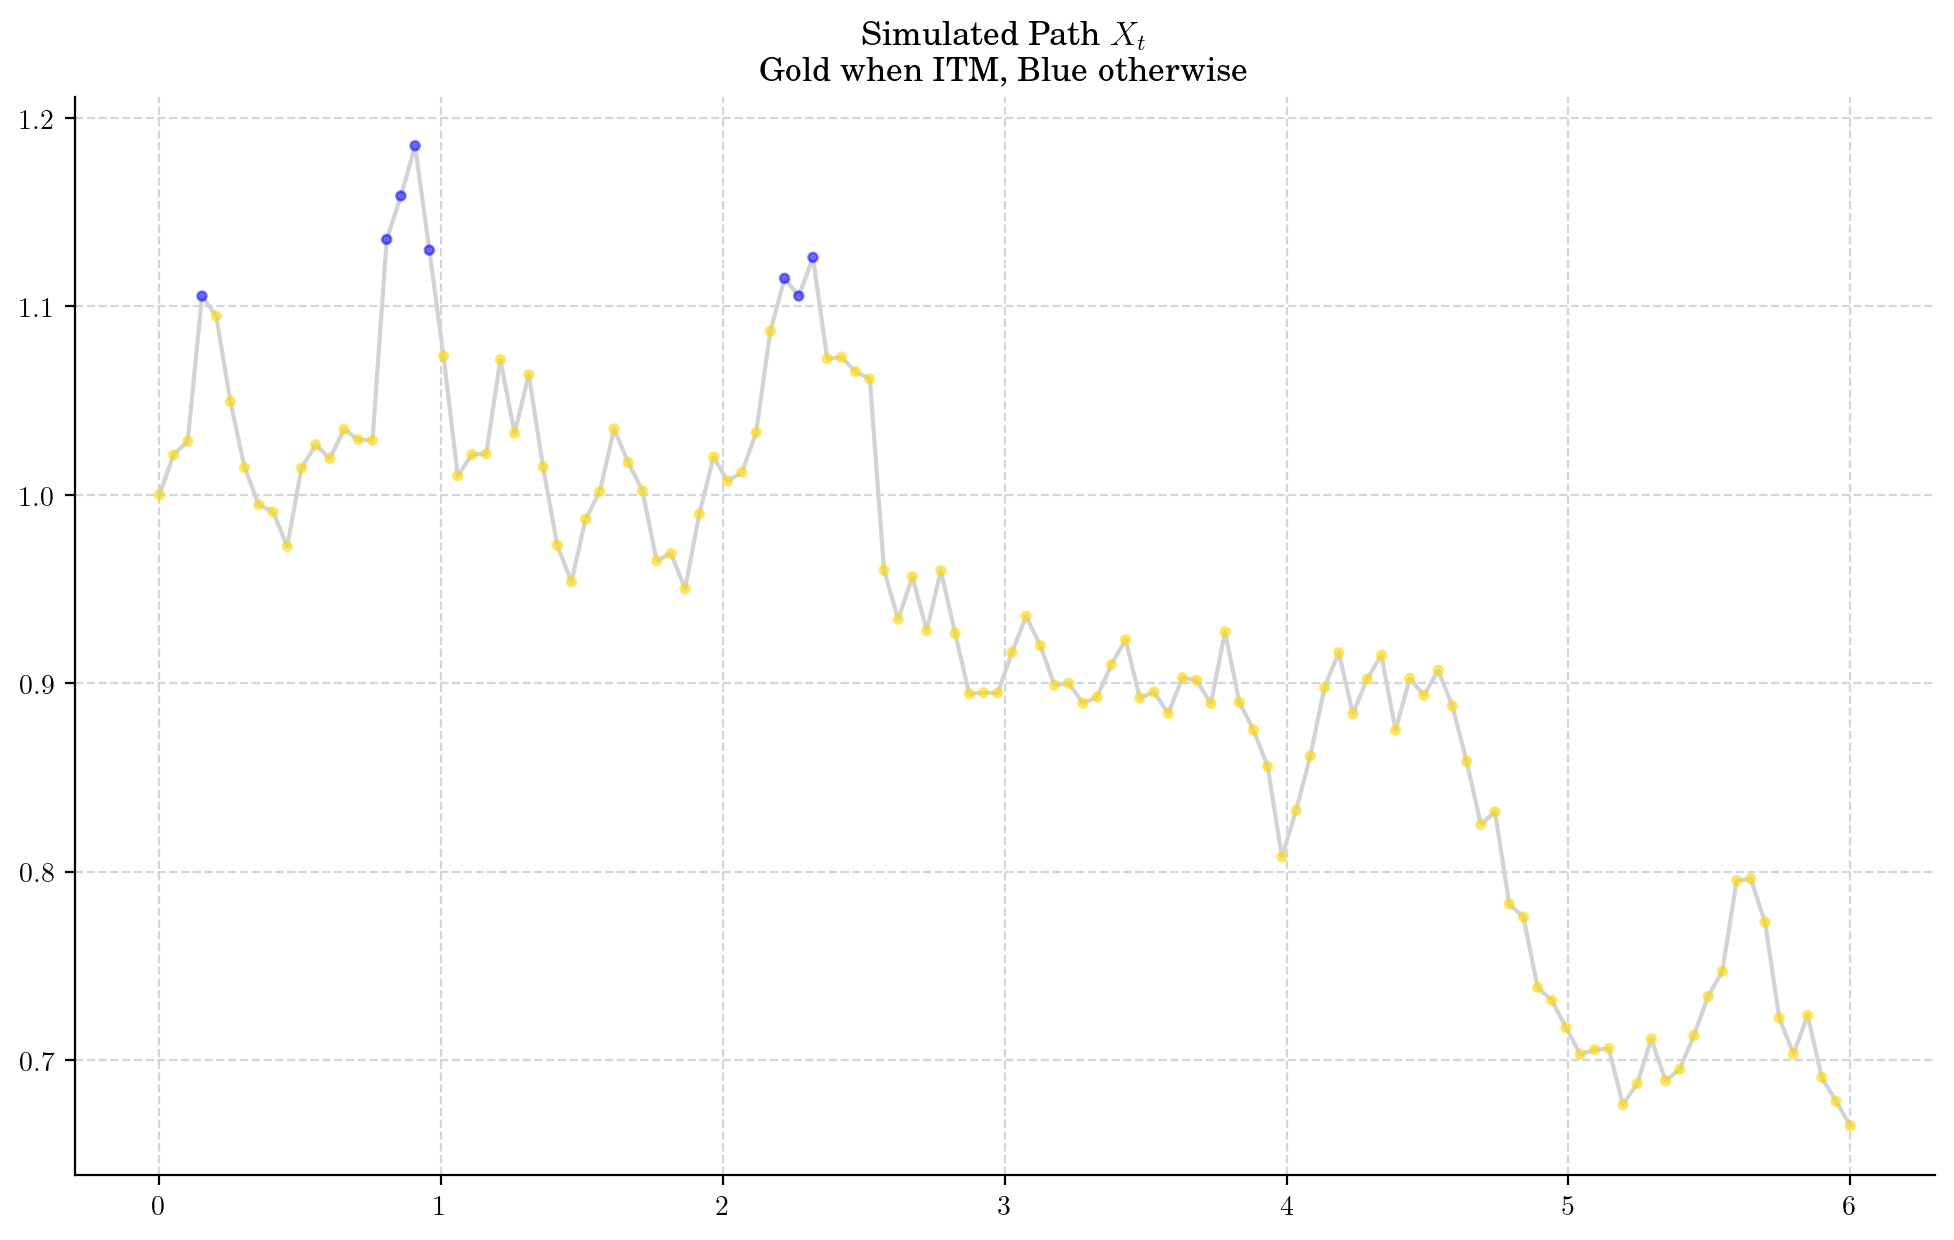

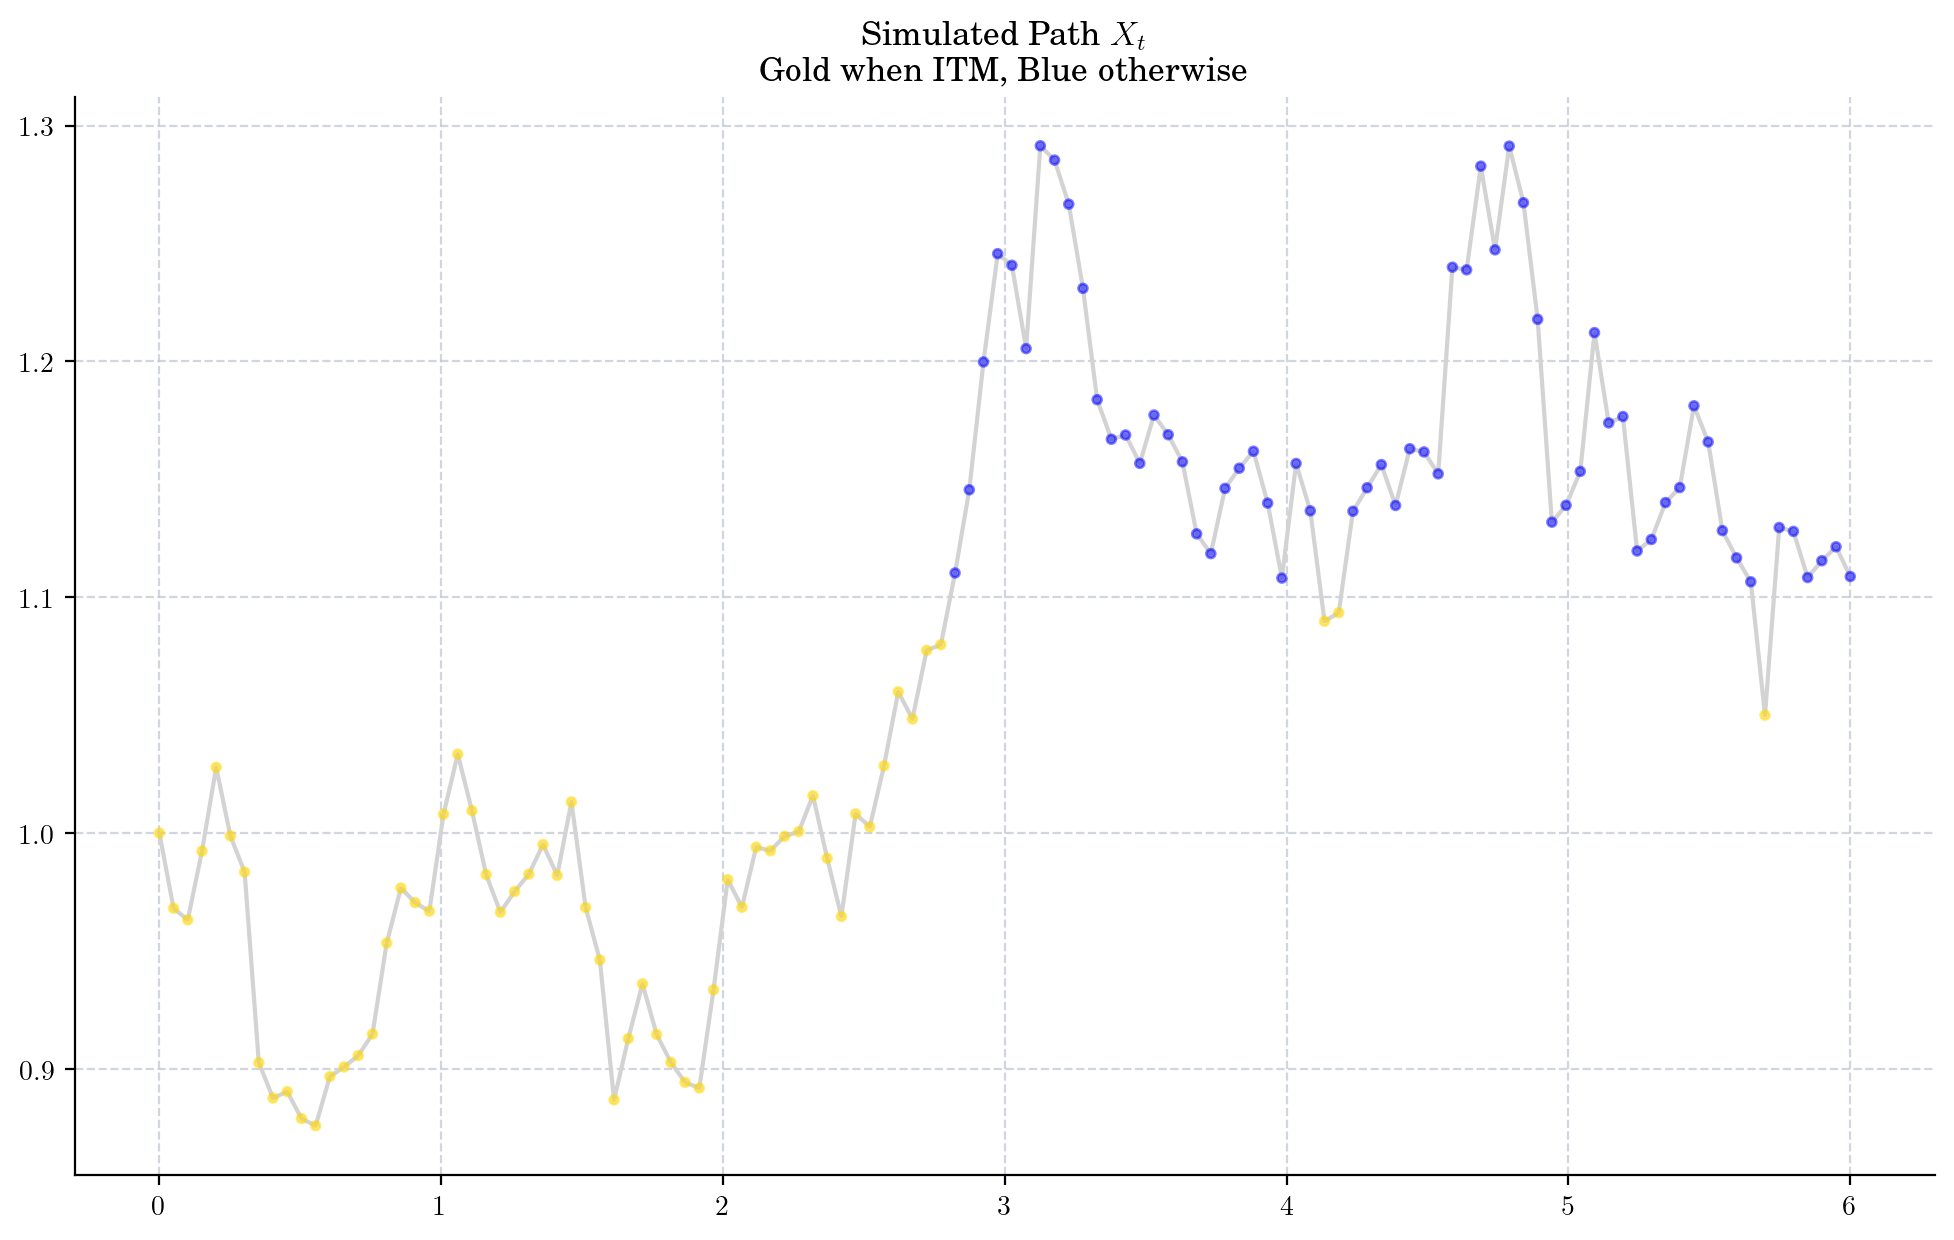

In [39]:
for path in [paths[0], paths[10], paths[20], paths[30]]:
    colors = ['gold' if (x<K) else 'blue' for x in path]
    plt.plot(times, path, color="lightgray")
    plt.scatter(times, path, c=colors, s=10, zorder=3, alpha=0.5)
    plt.title("Simulated Path $X_t$\n Gold when ITM, Blue otherwise")
    plt.show()

Next, we implement the payoff/exercise function and plot it.

In [40]:
def exercise_value(x):
    return np.maximum(K - x, 0)

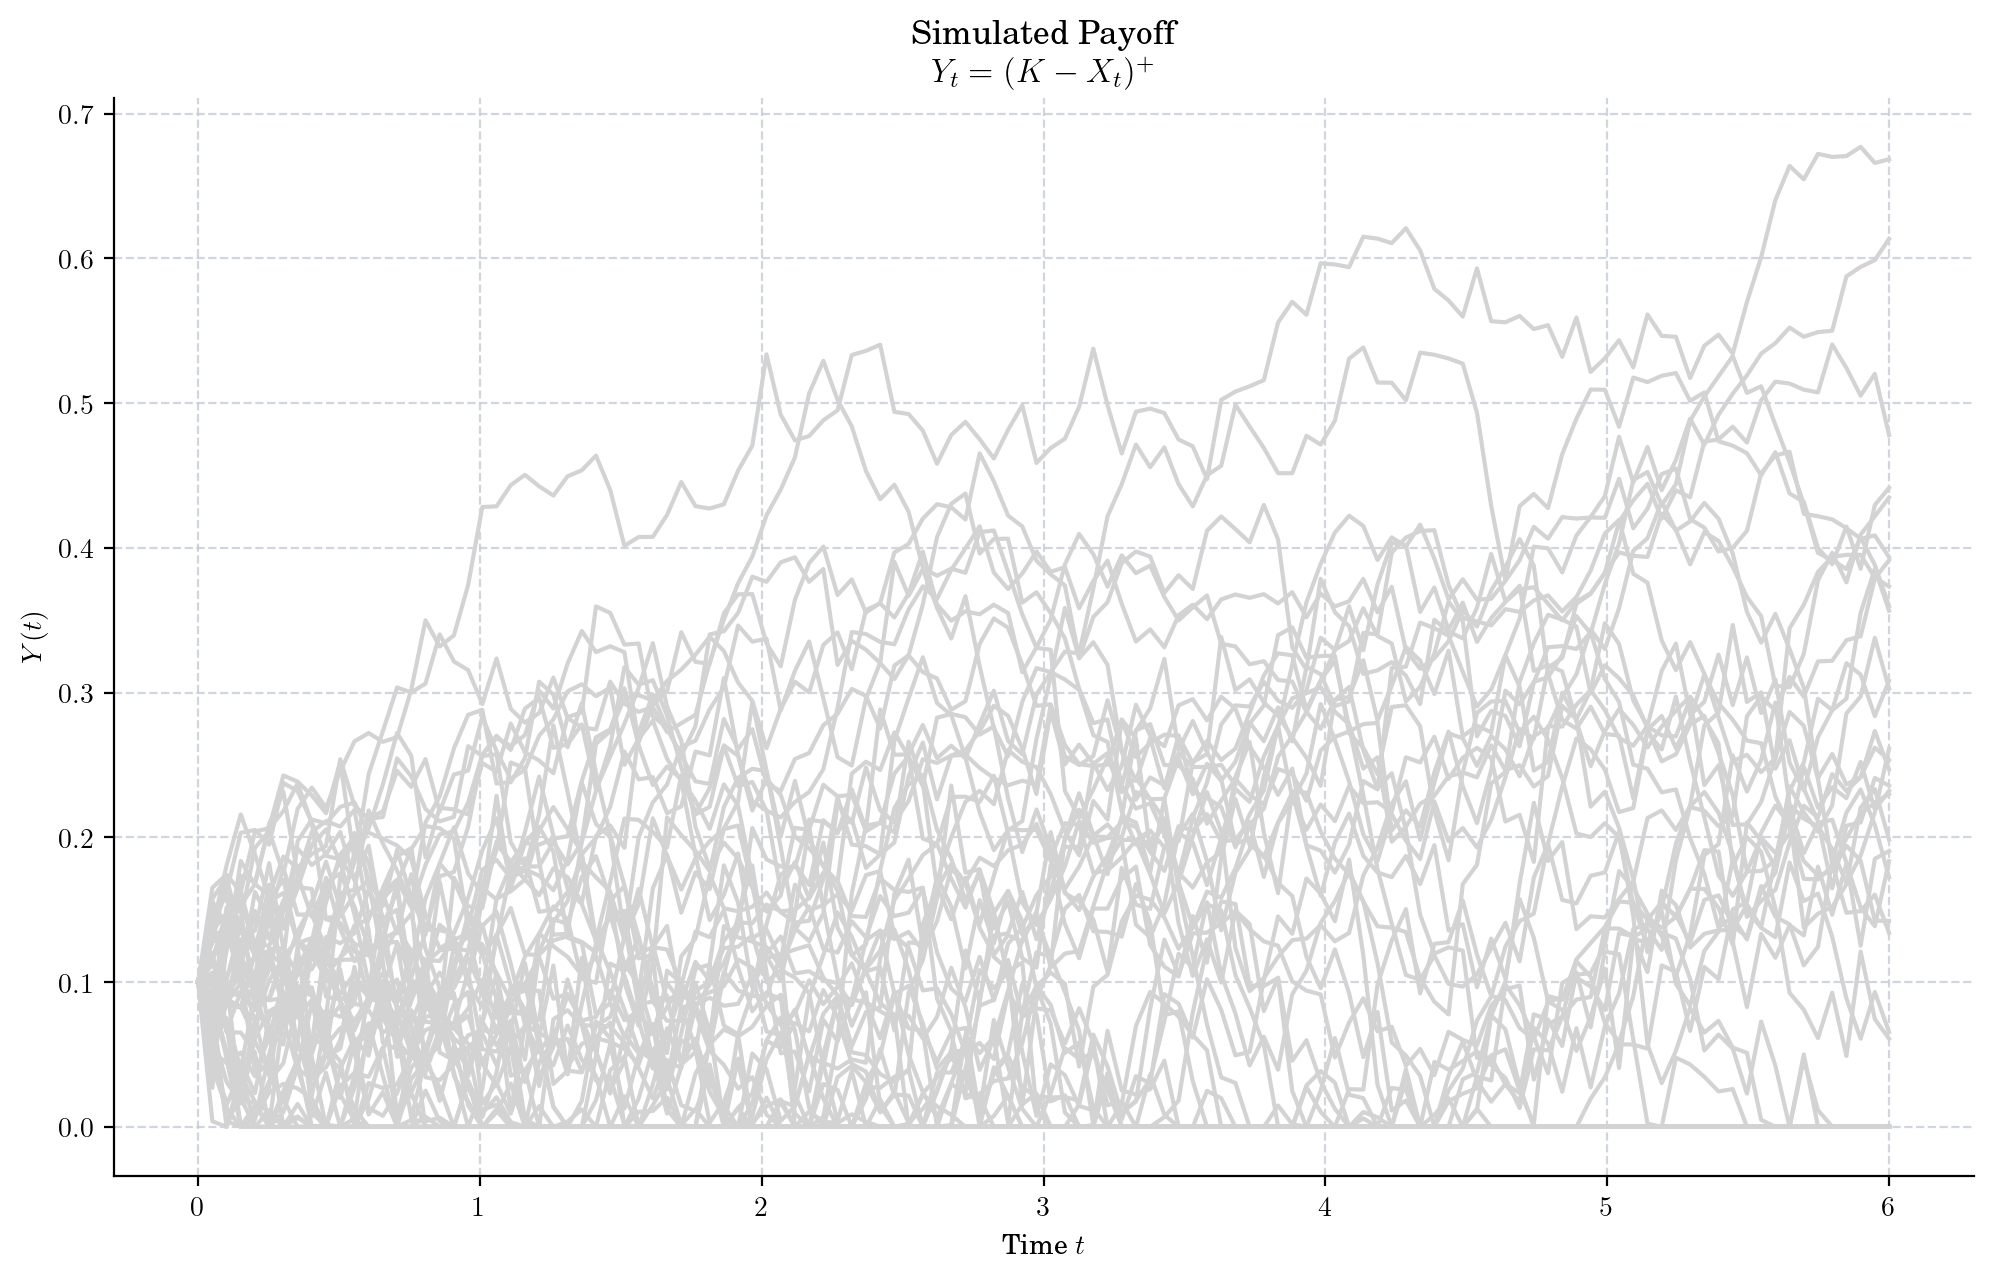

In [41]:
for path in paths:
    plt.plot(times, exercise_value(path), color="lightgray")
plt.title("Simulated Payoff\n$Y_t =(K - X_t)^+$")
plt.ylabel("$Y(t)$")
plt.xlabel("Time $t$")
plt.show()


- A every time $t_{i}$, the holder can exercise the option to obtain the payoff, i.e.:

$$\hbox{Exercise Value} = Y(t_{i}) = (K -X(t_{i}))^+.$$

- We want to estimate the Continuation Value,

$$ \hbox{Continuation Value} = C(t_{i}) = ?$$

## Longstaff-Schwartz Algorithm


- This is a backwards algorithm, so we will start at time $T=t_n$. 

- At time $t_n$, the option value is exactly the payoff as there is no more time left.

$$U(t_n) = Y(t_n) = (K -X(t_{n}))^+.$$


- A time $t_{n-1}$,  we want to find what is the best choice between Exercise and Continuation, i.e.:

$$U(t_{n-1}) = \max\left\{  Y(t_{n-1}),  C(t_{n-1})\right\},$$

where 

$$C(t_{n-1}) = D(t_n, t_{n-1}) \mathbb{E}[U(t_n) \mid \mathcal{F}_{n-1}]$$
The value of exercise is 

$$\hbox{Exercise Value} = Y(t_{n-1}) = (K -X(t_{n-1}))^+.$$


Now the key observation is that **if** the holder decides not to exercise, then our option behaves like an European one (the exercise decision has to be made in the next step and there is no early exit choice) over the period $[t_{n-1}, t_n]$. Thus, we know the discounted value of the option would be given by

$$ \hbox{Discounted Cashflow} = V(t_{n-1}, t_n) = e^{-r(t_n - t_{n-1})}( K - X(t_n))^+.$$

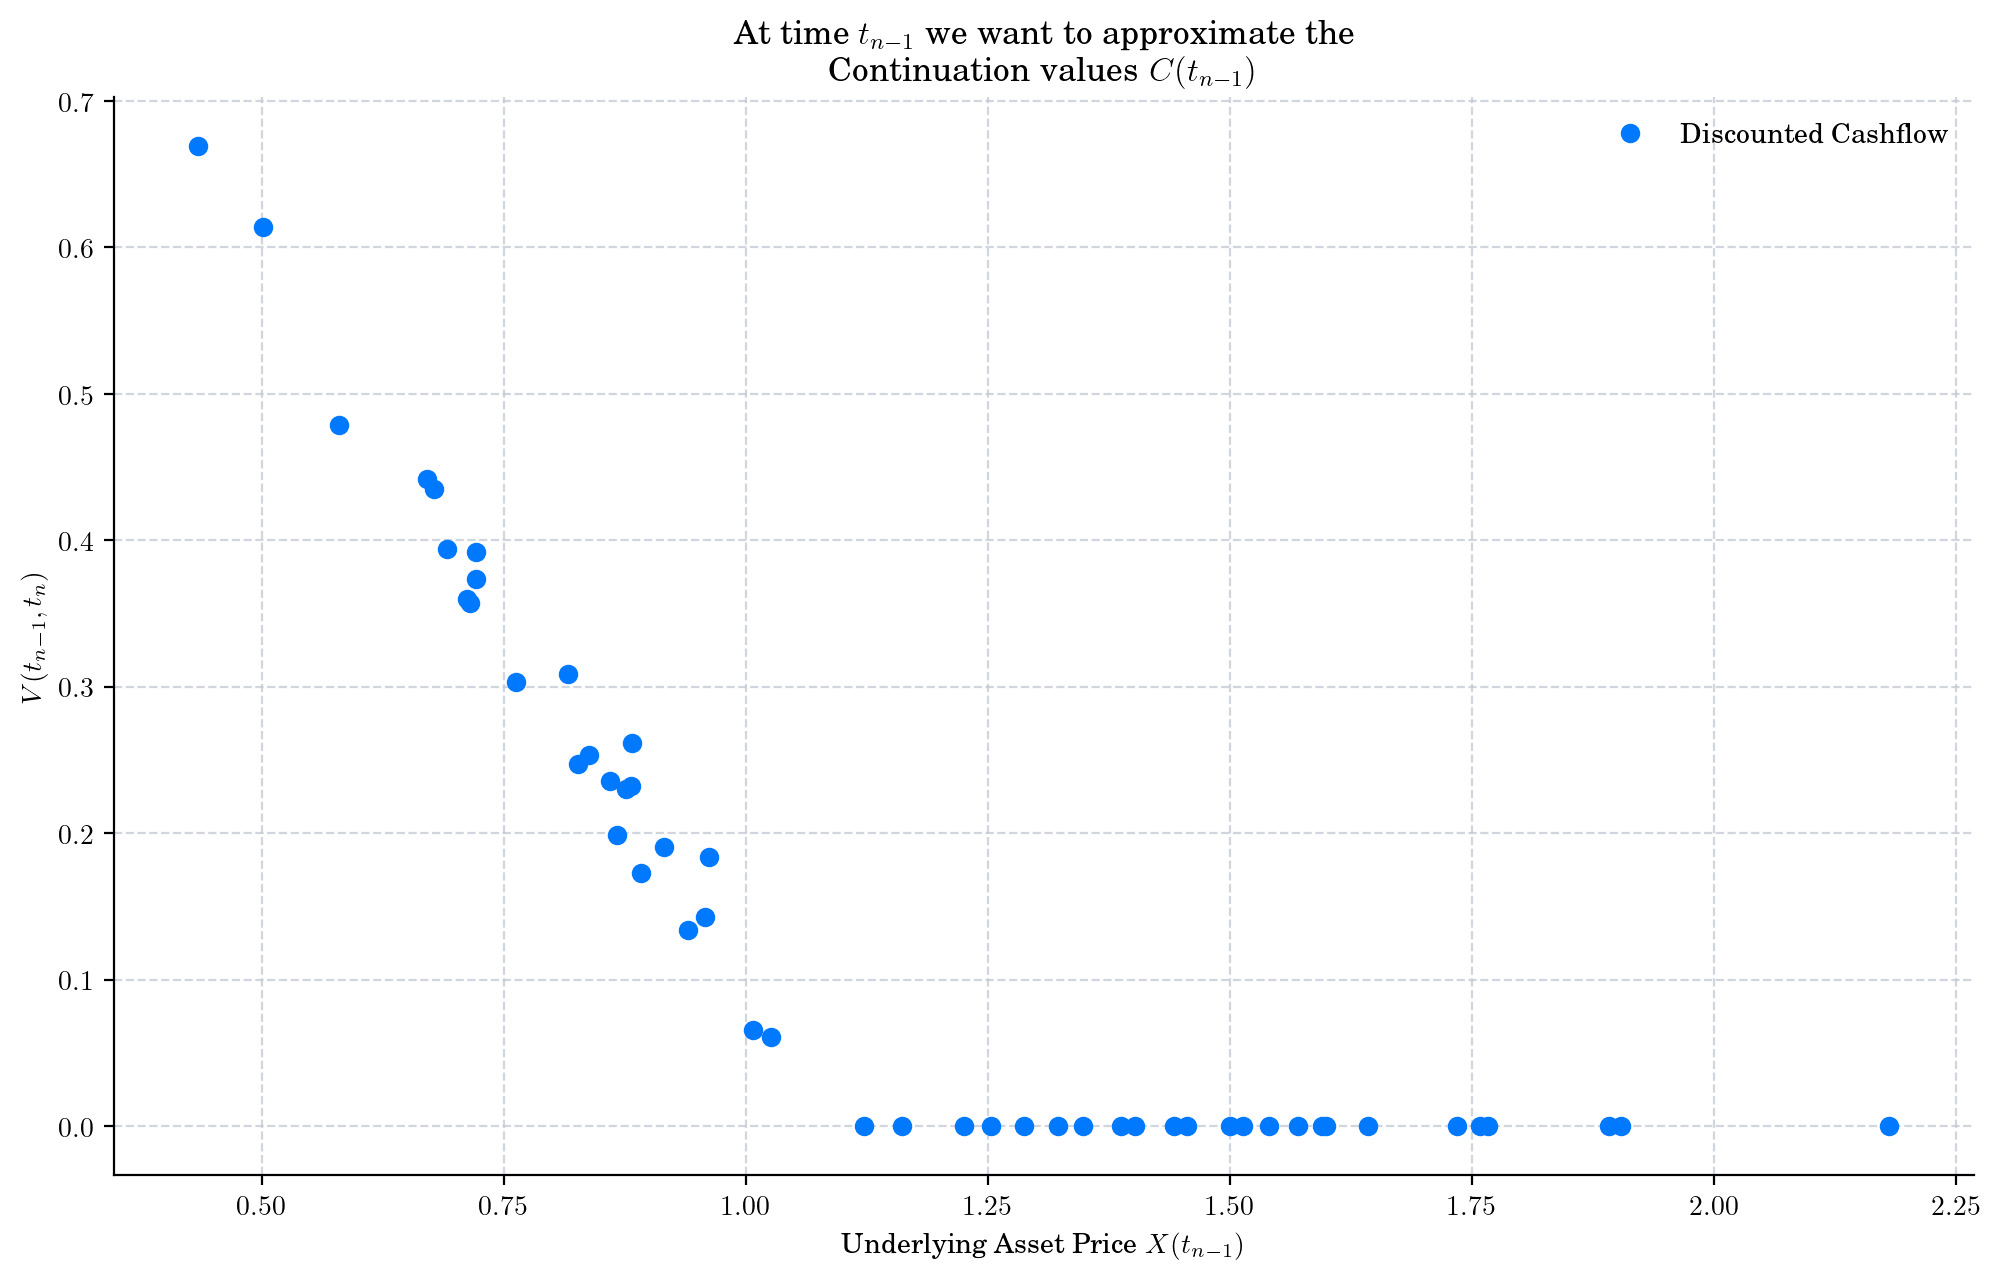

In [42]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (times[-2] - times[-1]))
x = X[-2, :]
plt.figure()
plt.plot(x, cashflow, "o", label="Discounted Cashflow")
plt.ylabel("$V(t_{n-1},t_n)$")
plt.xlabel("Underlying Asset Price $X(t_{n-1})$")
plt.title("At time $t_{n-1}$ we want to approximate the\nContinuation values $C(t_{n-1})$")
plt.legend()
plt.show()

So, the idea of the Longstaff-Schwartz Algorithm is to use the least-squares method to fit a polynomial function to the pairs
\begin{equation*}
			(X(t_{n-1}, \omega), V(t_{n-1}, t_{n}, \omega)),
\end{equation*}
and then use such polynomial to approximate the continuation value as follows:
\begin{equation}
		   C(t_{n-1}) \approx \sum_{j=0}^{\infty} \hat{\alpha}_{ij} L_{j}(X(t_i)).
\end{equation}

There are two choices to make here:

- Type of Polynomial e.g. Laguerre, Hermite, Chebyshev, Jacobi
- Degree of the Polynomial 

We can try with a Laguerre polynomial of dregree 4.

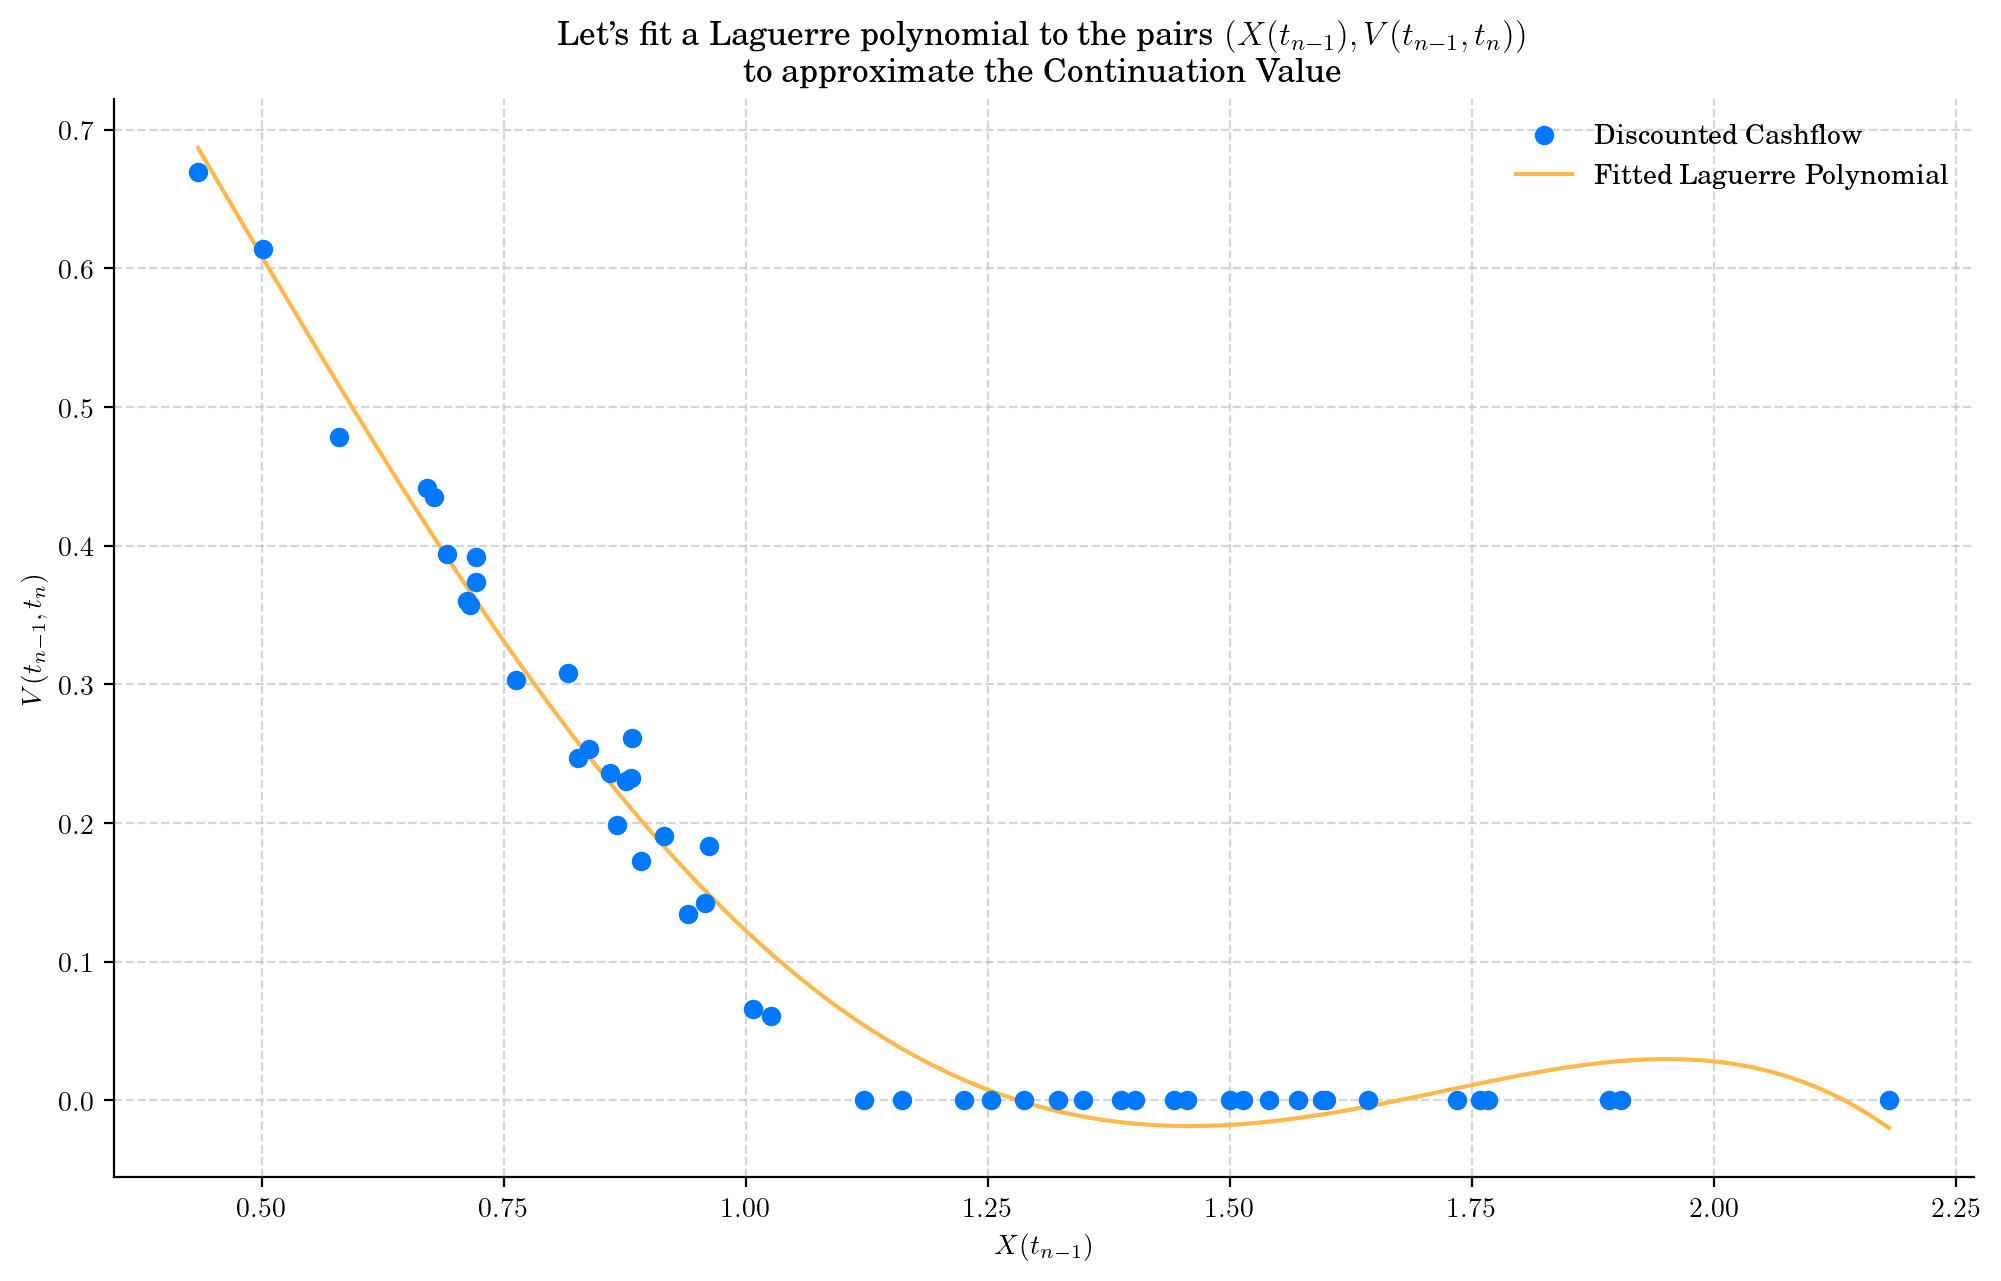

Laguerre([ -47.05867405,  211.30139919, -353.88147977,  262.7645973 ,
        -72.43910865], domain=[0.43406058, 2.1804147 ], window=[0., 1.], symbol='x')

In [43]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (times[-2] - times[-1]))
x = X[-2, :]
plt.figure()
plt.plot(x, cashflow, "o", label="Discounted Cashflow", zorder=3)
fitted = np.polynomial.Laguerre.fit(x, cashflow, 4)
plt.plot(*fitted.linspace(), label="Fitted Laguerre Polynomial")
plt.xlabel("$X(t_{n-1})$")
plt.ylabel("$V(t_{n-1}, t_n)$")
plt.legend()
plt.title("Let's fit a Laguerre polynomial to the pairs $(X(t_{n-1}), V(t_{n-1}, t_n))$\n to approximate the Continuation Value")
plt.show()
fitted

We can try other choices!

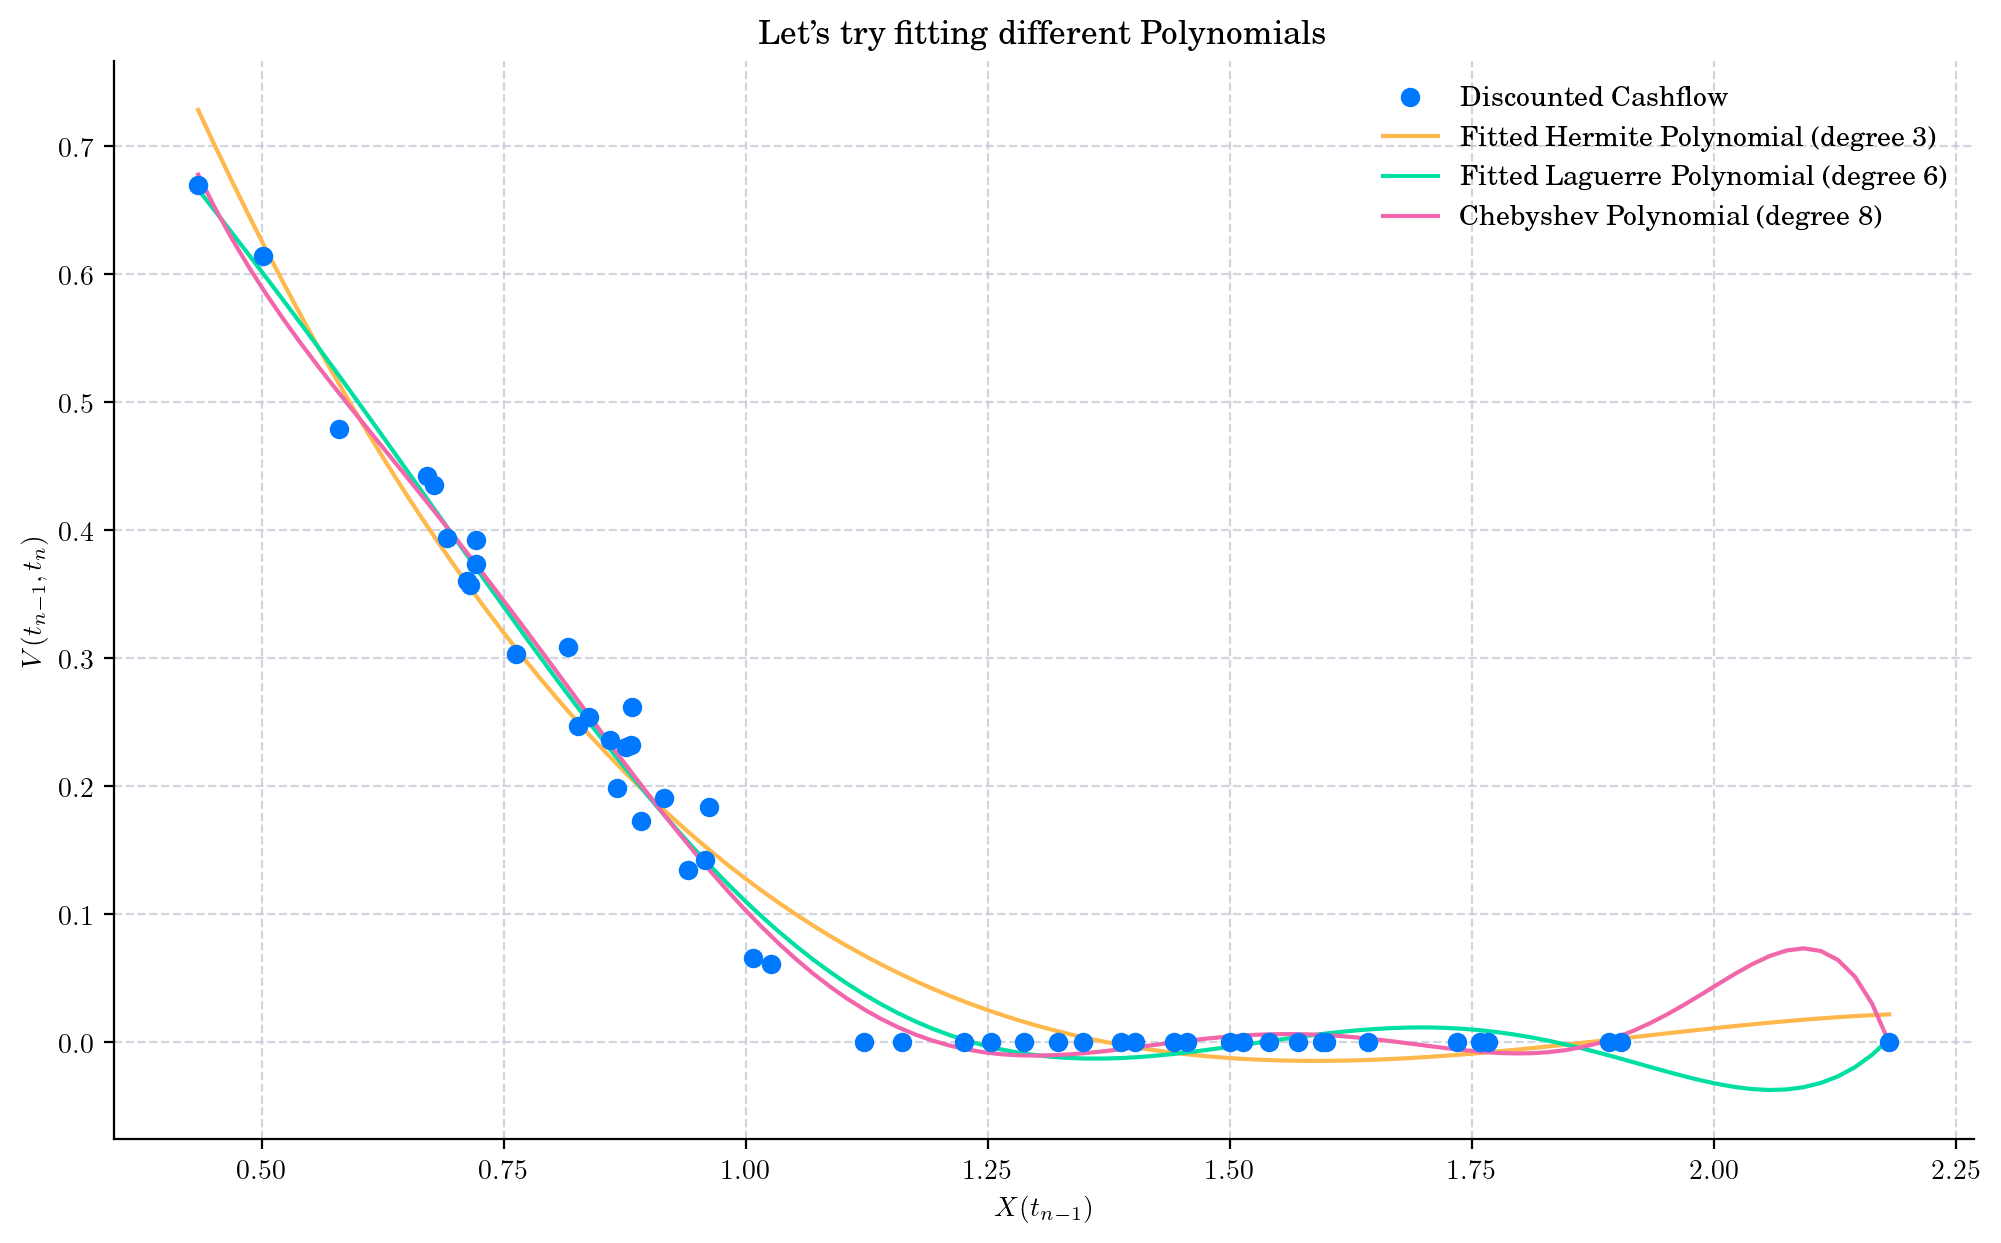

In [44]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (times[-2] - times[-1]))
x = X[-2, :]
plt.figure()
plt.plot(x, cashflow, "o", label="Discounted Cashflow", zorder=3)
fitted = np.polynomial.Hermite.fit(x, cashflow, 3)
fitted_laguerre = np.polynomial.Laguerre.fit(x, cashflow, 6)
fitted_chebyshev = np.polynomial.Chebyshev.fit(x, cashflow, 8)
plt.plot(*fitted.linspace(), label="Fitted Hermite Polynomial (degree 3)")
plt.plot(*fitted_laguerre.linspace(), label="Fitted Laguerre Polynomial (degree 6)")
plt.plot(*fitted_chebyshev.linspace(), label="Chebyshev Polynomial (degree 8)")
plt.xlabel("$X(t_{n-1})$")
plt.ylabel("$V(t_{n-1}, t_n)$")
plt.legend()
plt.title("Let's try fitting different Polynomials")
plt.show()

In [45]:
fitted

Hermite([ 0.19312442, -0.21988906,  0.09086481, -0.02163984], domain=[0.43406058, 2.1804147 ], window=[-1.,  1.], symbol='x')

In [46]:
fitted_laguerre

Laguerre([   9809.43769908,  -63186.02606291,  169547.82467888,
       -242565.33193549,  195128.44293811,  -83676.37311119,
         14942.69180655], domain=[0.43406058, 2.1804147 ], window=[0., 1.], symbol='x')

In [47]:
fitted_chebyshev

Chebyshev([ 0.19117065, -0.28544467,  0.18116391, -0.03691178, -0.0216905 ,
        0.00596226, -0.00657806, -0.02253211, -0.00540859], domain=[0.43406058, 2.1804147 ], window=[-1.,  1.], symbol='x')

Once we have made these choices, we can proceed to approximate the Continuation Value.

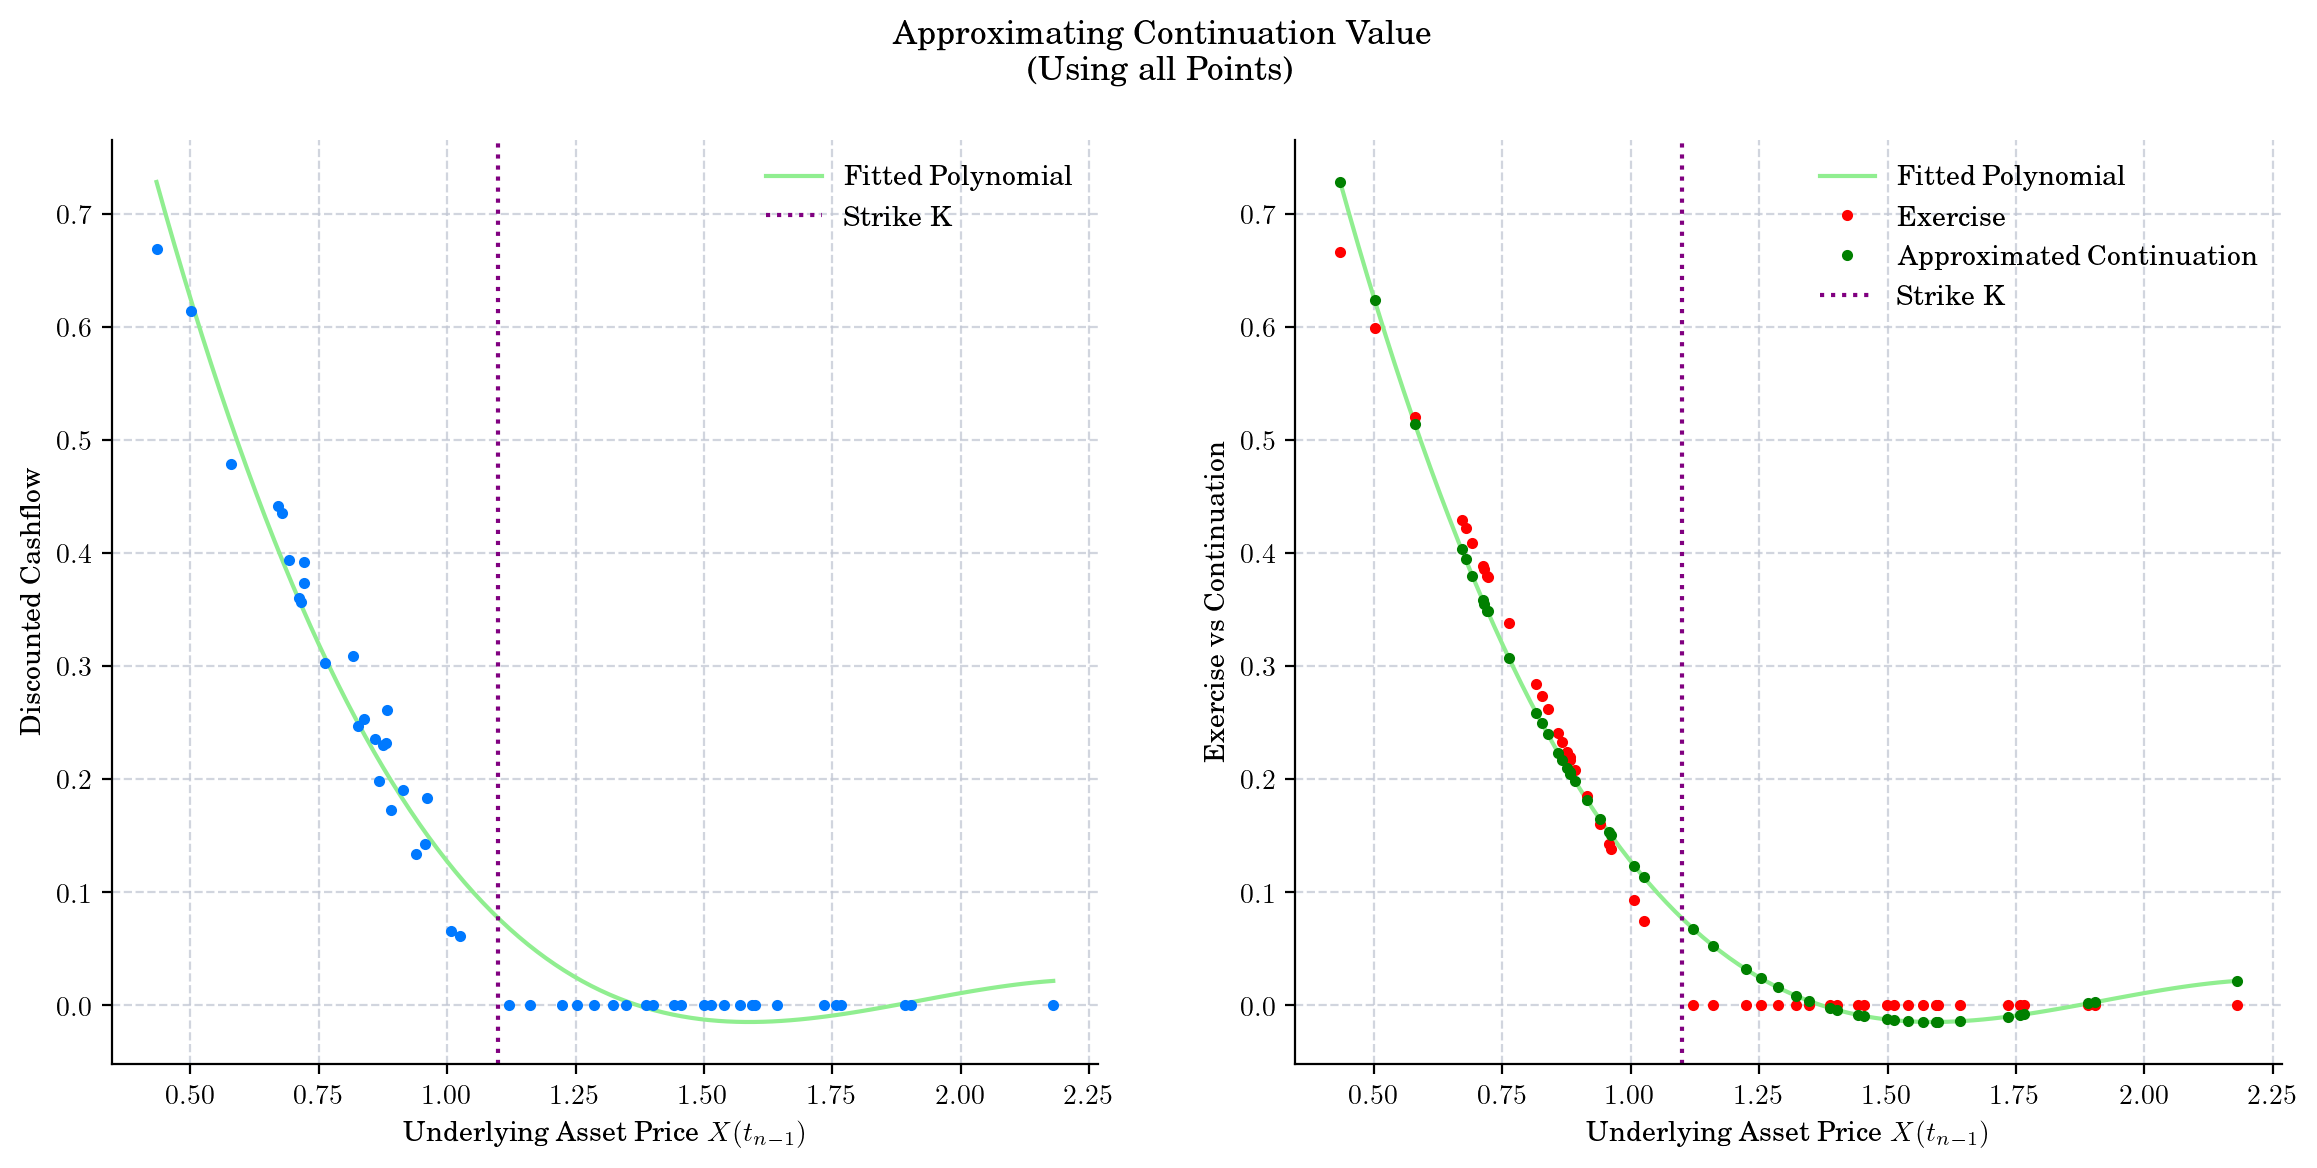

Polynomial([ 0.0113948 , -0.18010008,  0.36345924, -0.17311869], domain=[0.43406058, 2.1804147 ], window=[-1.,  1.], symbol='x')

In [48]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (times[-2] - times[-1]))
x = X[-2, :]
exercise = exercise_value(x)
fitted = np.polynomial.Polynomial.fit(x, cashflow, 3)
continuation = fitted(x)

fig, axs = plt.subplots(1, 2, figsize=(14,6))
axs[0].plot(x, cashflow, ".", zorder=3)
axs[0].plot(*fitted.linspace(),  color="lightgreen", label="Fitted Polynomial")
axs[0].axvline(x=1.1, linestyle=":", color="purple", label="Strike K")

axs[1].plot(*fitted.linspace(),  color="lightgreen", label="Fitted Polynomial")
axs[1].plot(x, exercise, '.', color="red", label="Exercise")
axs[1].plot(x, continuation, '.', color="green", label= "Approximated Continuation")
axs[1].axvline(x=1.1, linestyle=":", color="purple", label="Strike K")
axs[0].set_xlabel("Underlying Asset Price $X(t_{n-1})$")
axs[0].set_ylabel("Discounted Cashflow")
axs[1].set_xlabel("Underlying Asset Price $X(t_{n-1})$")
axs[1].set_ylabel("Exercise vs Continuation")
axs[0].legend()
axs[1].legend()
plt.suptitle("Approximating Continuation Value\n(Using all Points)")
plt.show()
fitted

Using only ITM points.

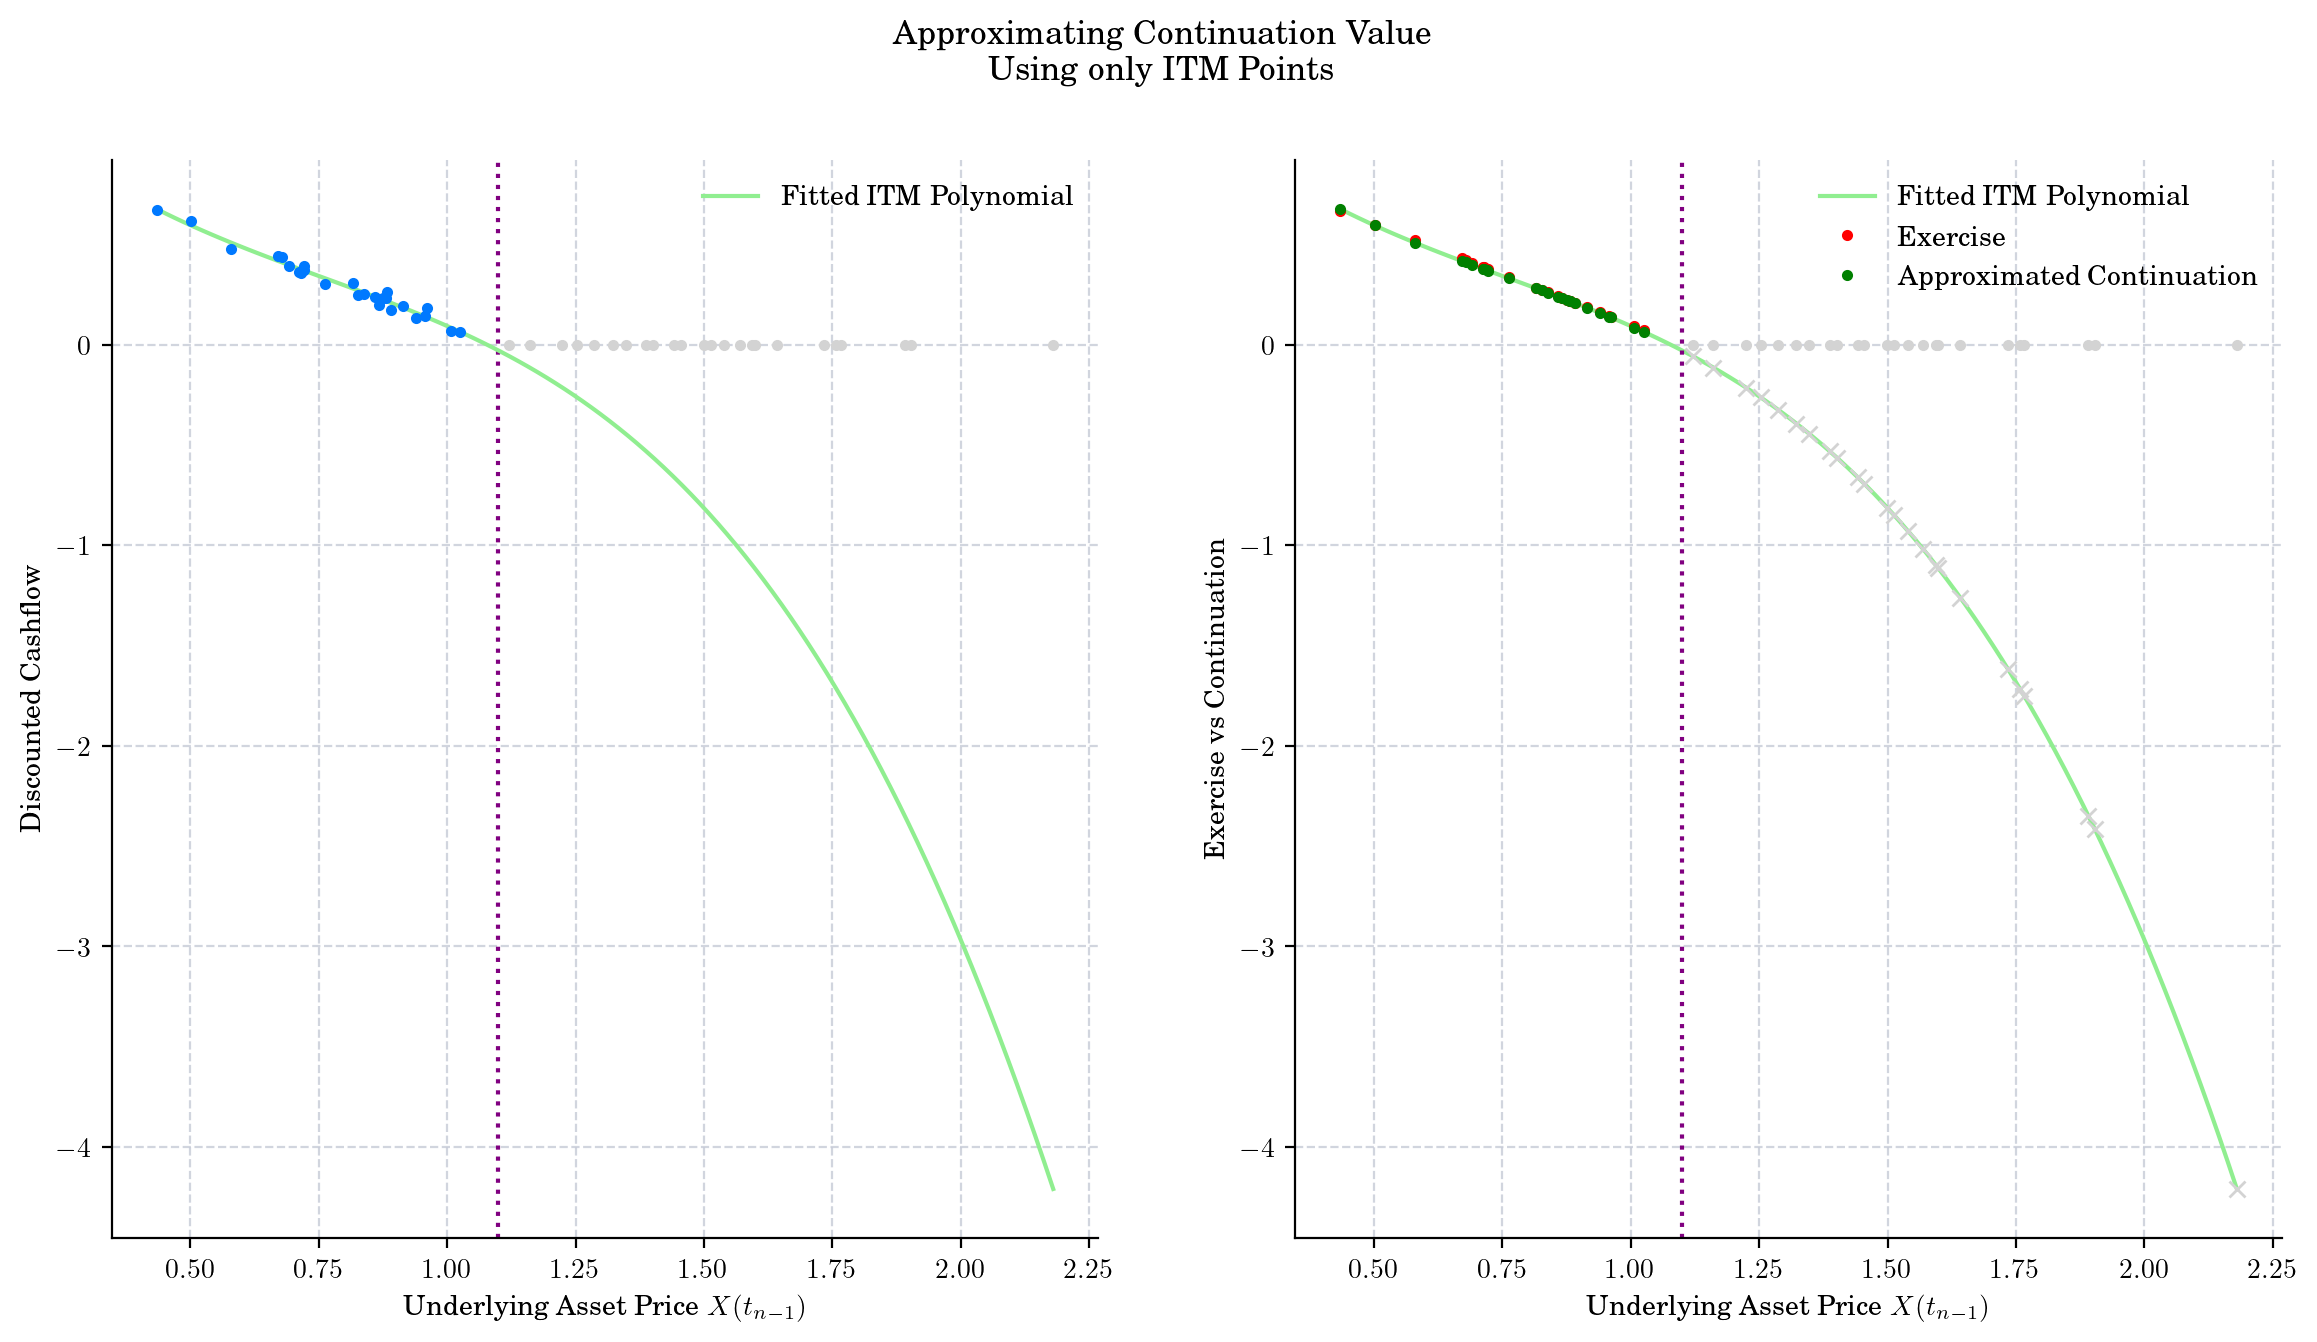

Polynomial([ 0.36114589, -0.27744465,  0.00865949, -0.02896749], domain=[0.43406058, 1.02556011], window=[-1.,  1.], symbol='x')

In [49]:
cashflow = exercise_value(X[-1, :]) * np.exp(-r * (times[-2] - times[-1]))
x = X[-2, :]
exercise = exercise_value(x)
itm = exercise>0

fitted_itm = np.polynomial.Polynomial.fit(x[itm], cashflow[itm], 3)
continuation = fitted_itm(x)

fig, axs = plt.subplots(1, 2, figsize=(14, 7))
axs[0].plot(x[itm], cashflow[itm], ".", zorder=3)
fitted_itm

axs[0].plot(x[~itm], cashflow[~itm], ".", zorder=3, color="lightgray")


axs[0].axvline(x=1.1, linestyle=":", color="purple")
aux = fitted.linspace()[0]
axs[0].plot(aux, fitted_itm(aux),label="Fitted ITM Polynomial", color="lightgreen")


axs[1].plot(aux, fitted_itm(aux),label="Fitted ITM Polynomial", color="lightgreen")
axs[1].plot(x[itm], exercise[itm], '.', color="red", label="Exercise")
axs[1].plot(x[itm], continuation[itm], '.', color="green",
            label="Approximated Continuation")

axs[1].axvline(x=1.1, linestyle=":", color="purple")

axs[1].plot(x[~itm], exercise[~itm], '.', color="lightgray")
axs[1].plot(x[~itm], fitted_itm(x[~itm]), 'x', color="lightgray")


axs[0].set_ylabel("Discounted Cashflow")
axs[1].set_ylabel("Exercise vs Continuation")

axs[0].set_xlabel("Underlying Asset Price $X(t_{n-1})$")
axs[1].set_xlabel("Underlying Asset Price $X(t_{n-1})$")

axs[0].legend()
axs[1].legend()
plt.suptitle("Approximating Continuation Value\n Using only ITM Points")
plt.show()
fitted_itm

In [50]:
intermediate_results = []
cashflow = exercise_value(X[-1, :])

# Iterating Backwards in Time
for i in reversed(range(1, X.shape[0] - 1)):
    # Discount Factor Between t[i] and t[i+1] (always the same since grid is equidistant)
    df = np.exp(-r * (times[i + 1] - times[i]))
    # Discounted cashflows from next period
    cashflow = cashflow * df
    # Price of the stock at current period
    x = X[i, :]
    # Exercise value at time t[i]
    exercise = exercise_value(x)
    # Index for In-the-Money paths
    itm = exercise_value(x) > 0
    # Fit polynomial to estimate Continuation Value at time t[i]
    fitted = np.polynomial.Polynomial.fit(x[itm], cashflow[itm], 3)
    # Estimate Continuation Value at time t[i]
    continuation = fitted(x)
    # Index where Exercise is Beneficial
    ex_idx = itm & (exercise > continuation)
    # Update cashflows with early exercises
    cashflow[ex_idx] = exercise[ex_idx]
    
    intermediate_results.append(
        (cashflow, x, fitted, continuation, exercise, ex_idx))

In [51]:
def plot_approx_n(n_steps, ax):
    cashflow, x, fitted, continuation, exercise, ex_idx = intermediate_results[n_steps]
    fitted_x, fitted_y = fitted.linspace()
    ax.axvline(x=1.1, linestyle=":", color="purple", label="$K$")
    ax.plot(x[ex_idx], exercise[ex_idx], ".", color="red", zorder=5, label="Favourable Exercise")
    ax.plot(x[~ex_idx], exercise[~ex_idx], ".", color="green", zorder=4, label="Unfavourable Exercise")
    ax.plot(fitted_x, fitted_y, zorder=2,color="lightgreen", label="Approximated Continuation Value")
    _x = np.linspace(np.min(x), np.max(x))
    ax.plot(_x, fitted(_x), "--", color="lightgrey", zorder=1)
    ax.legend()

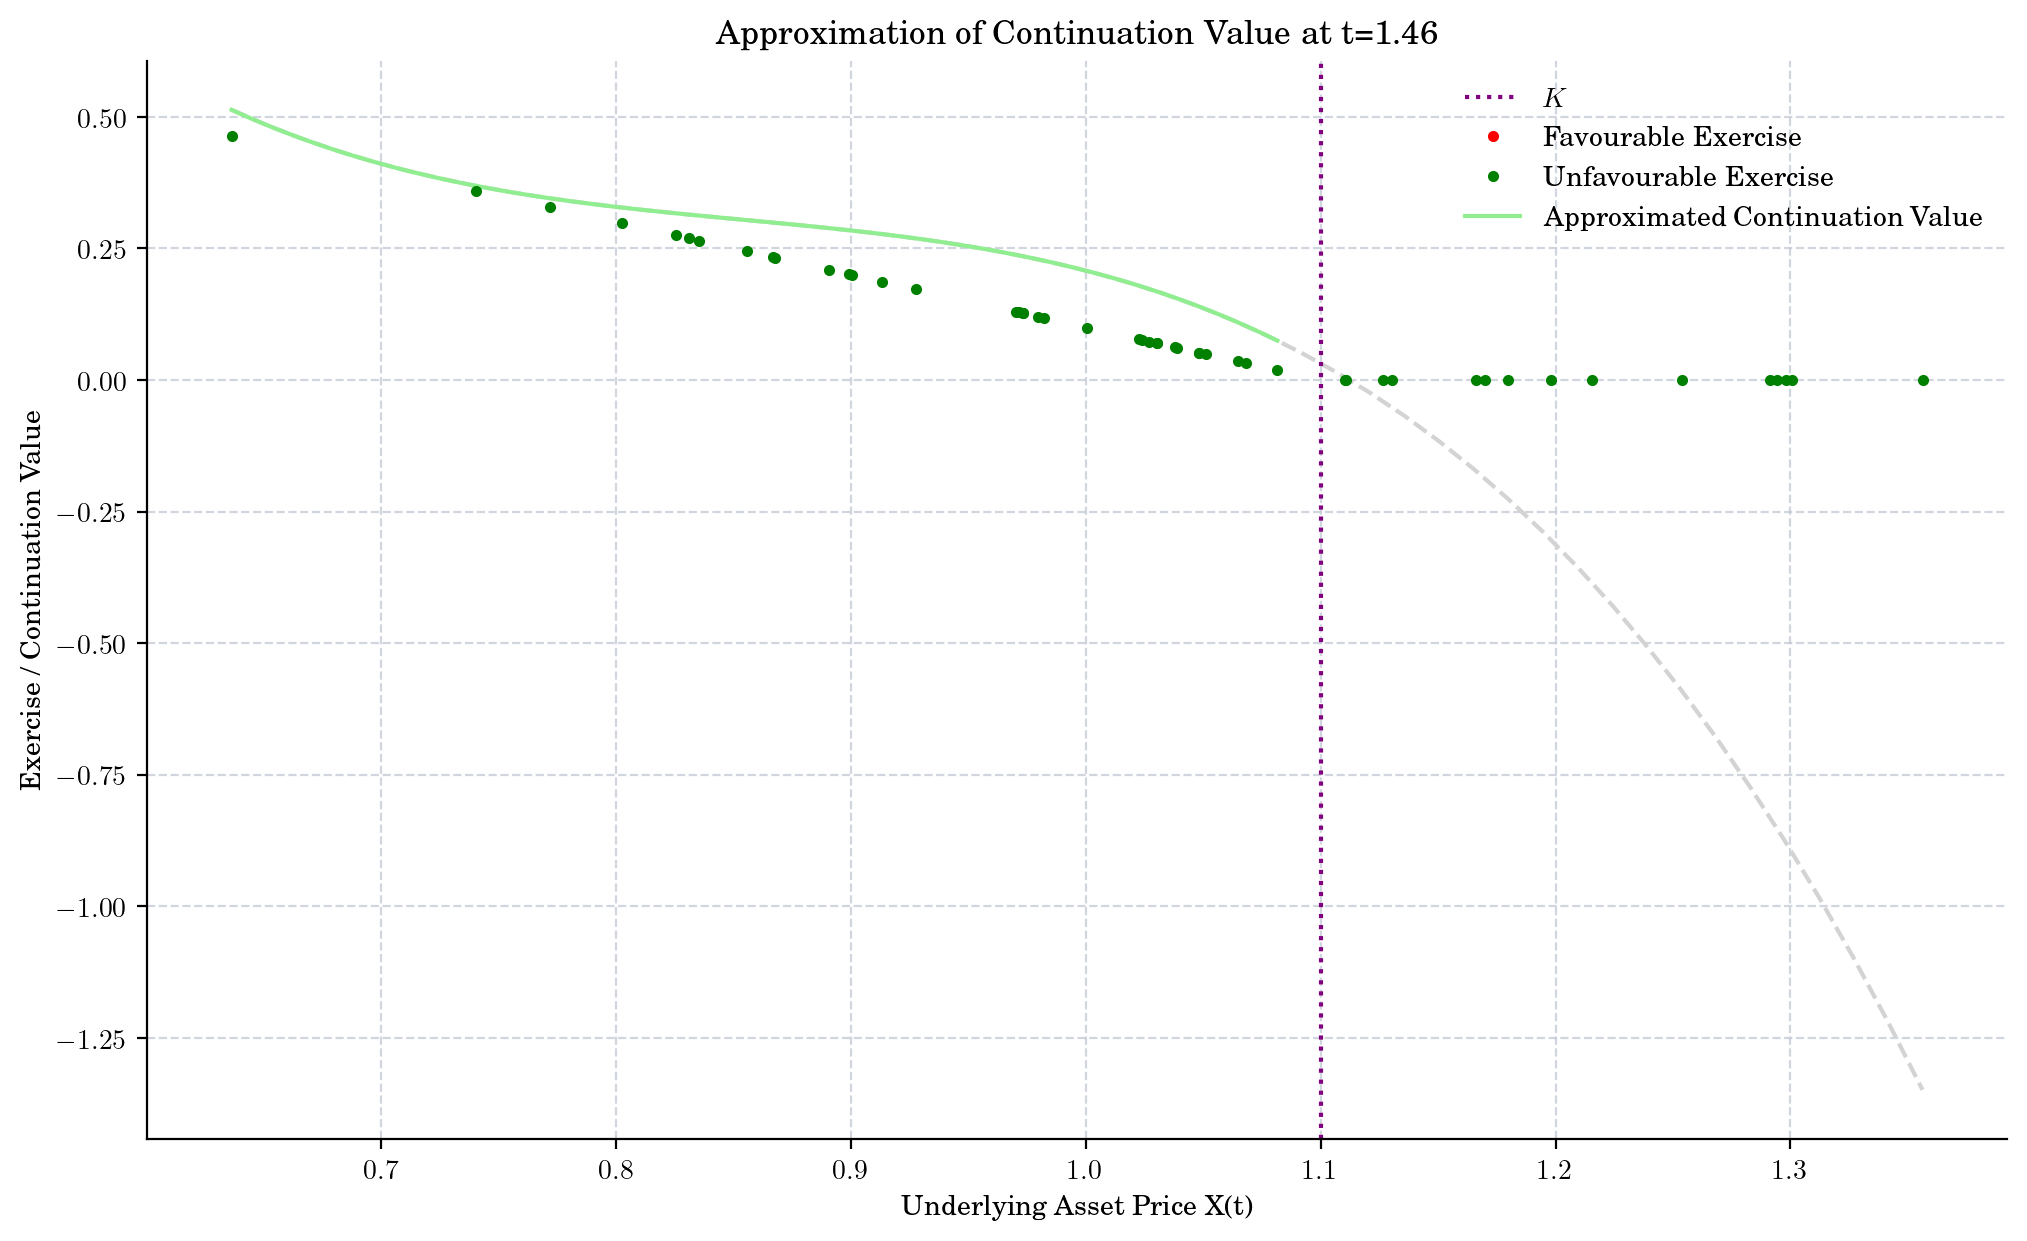

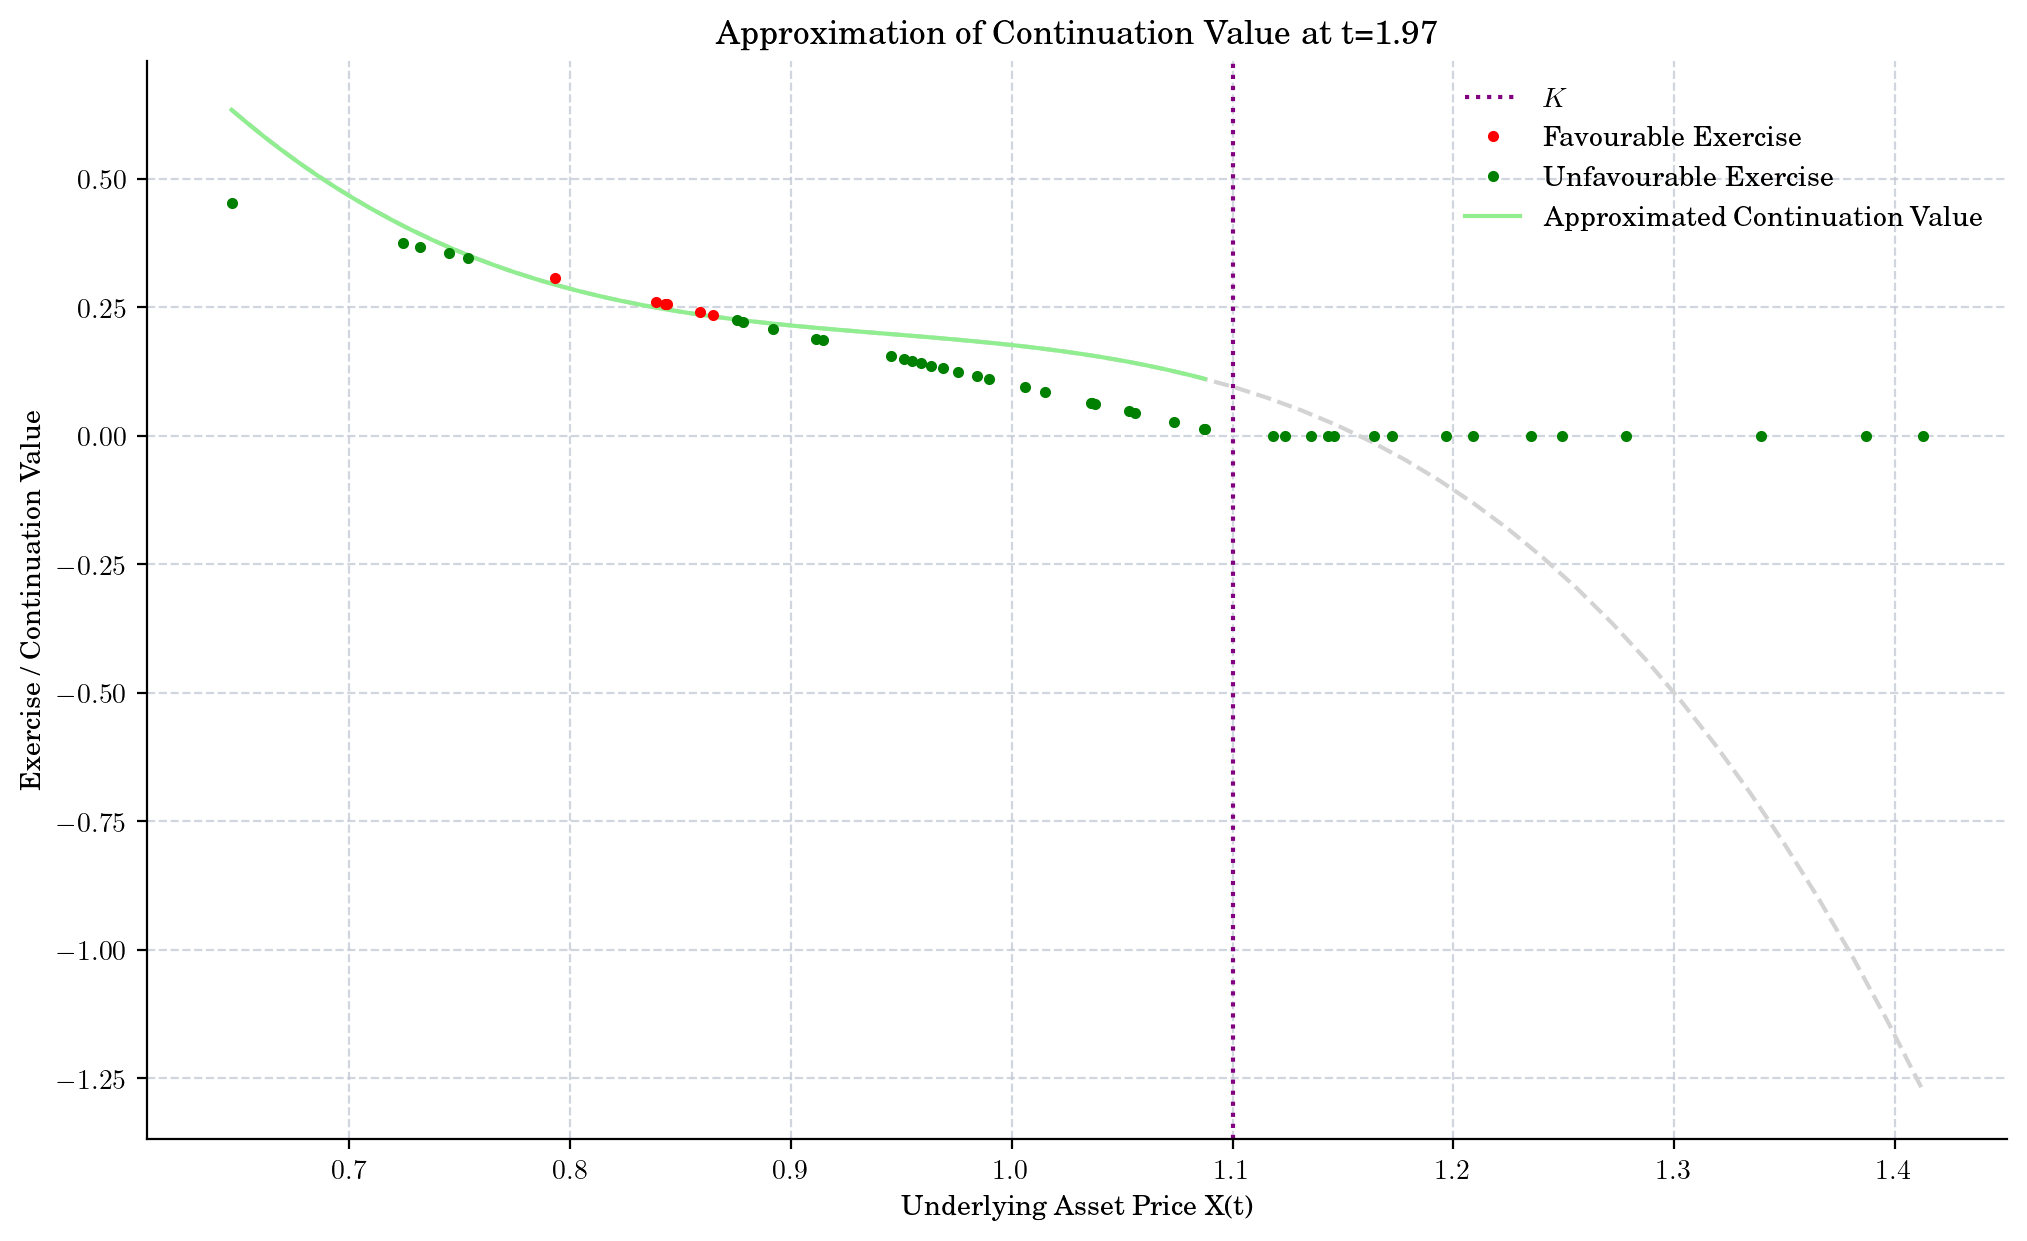

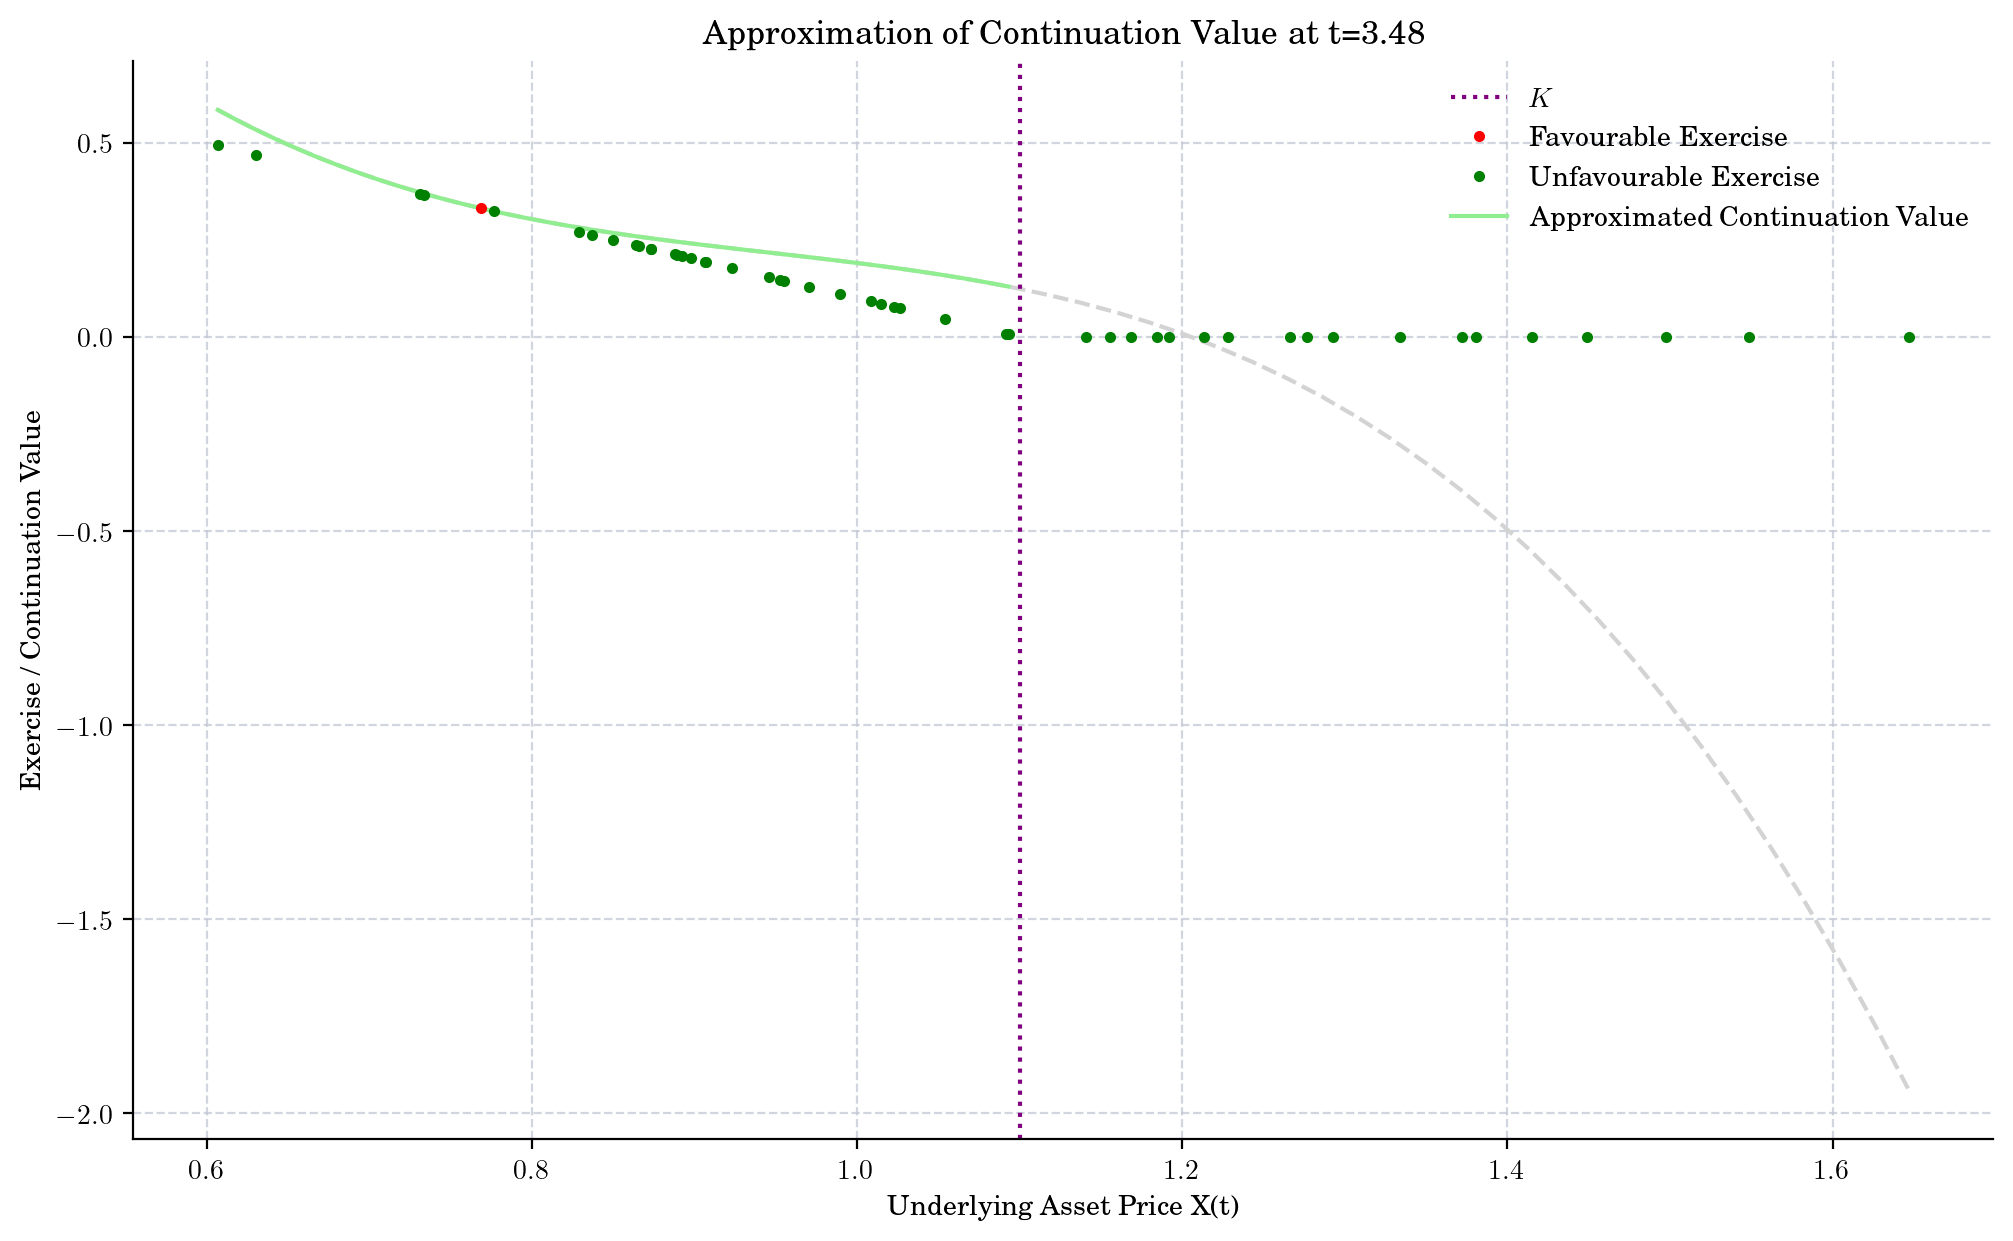

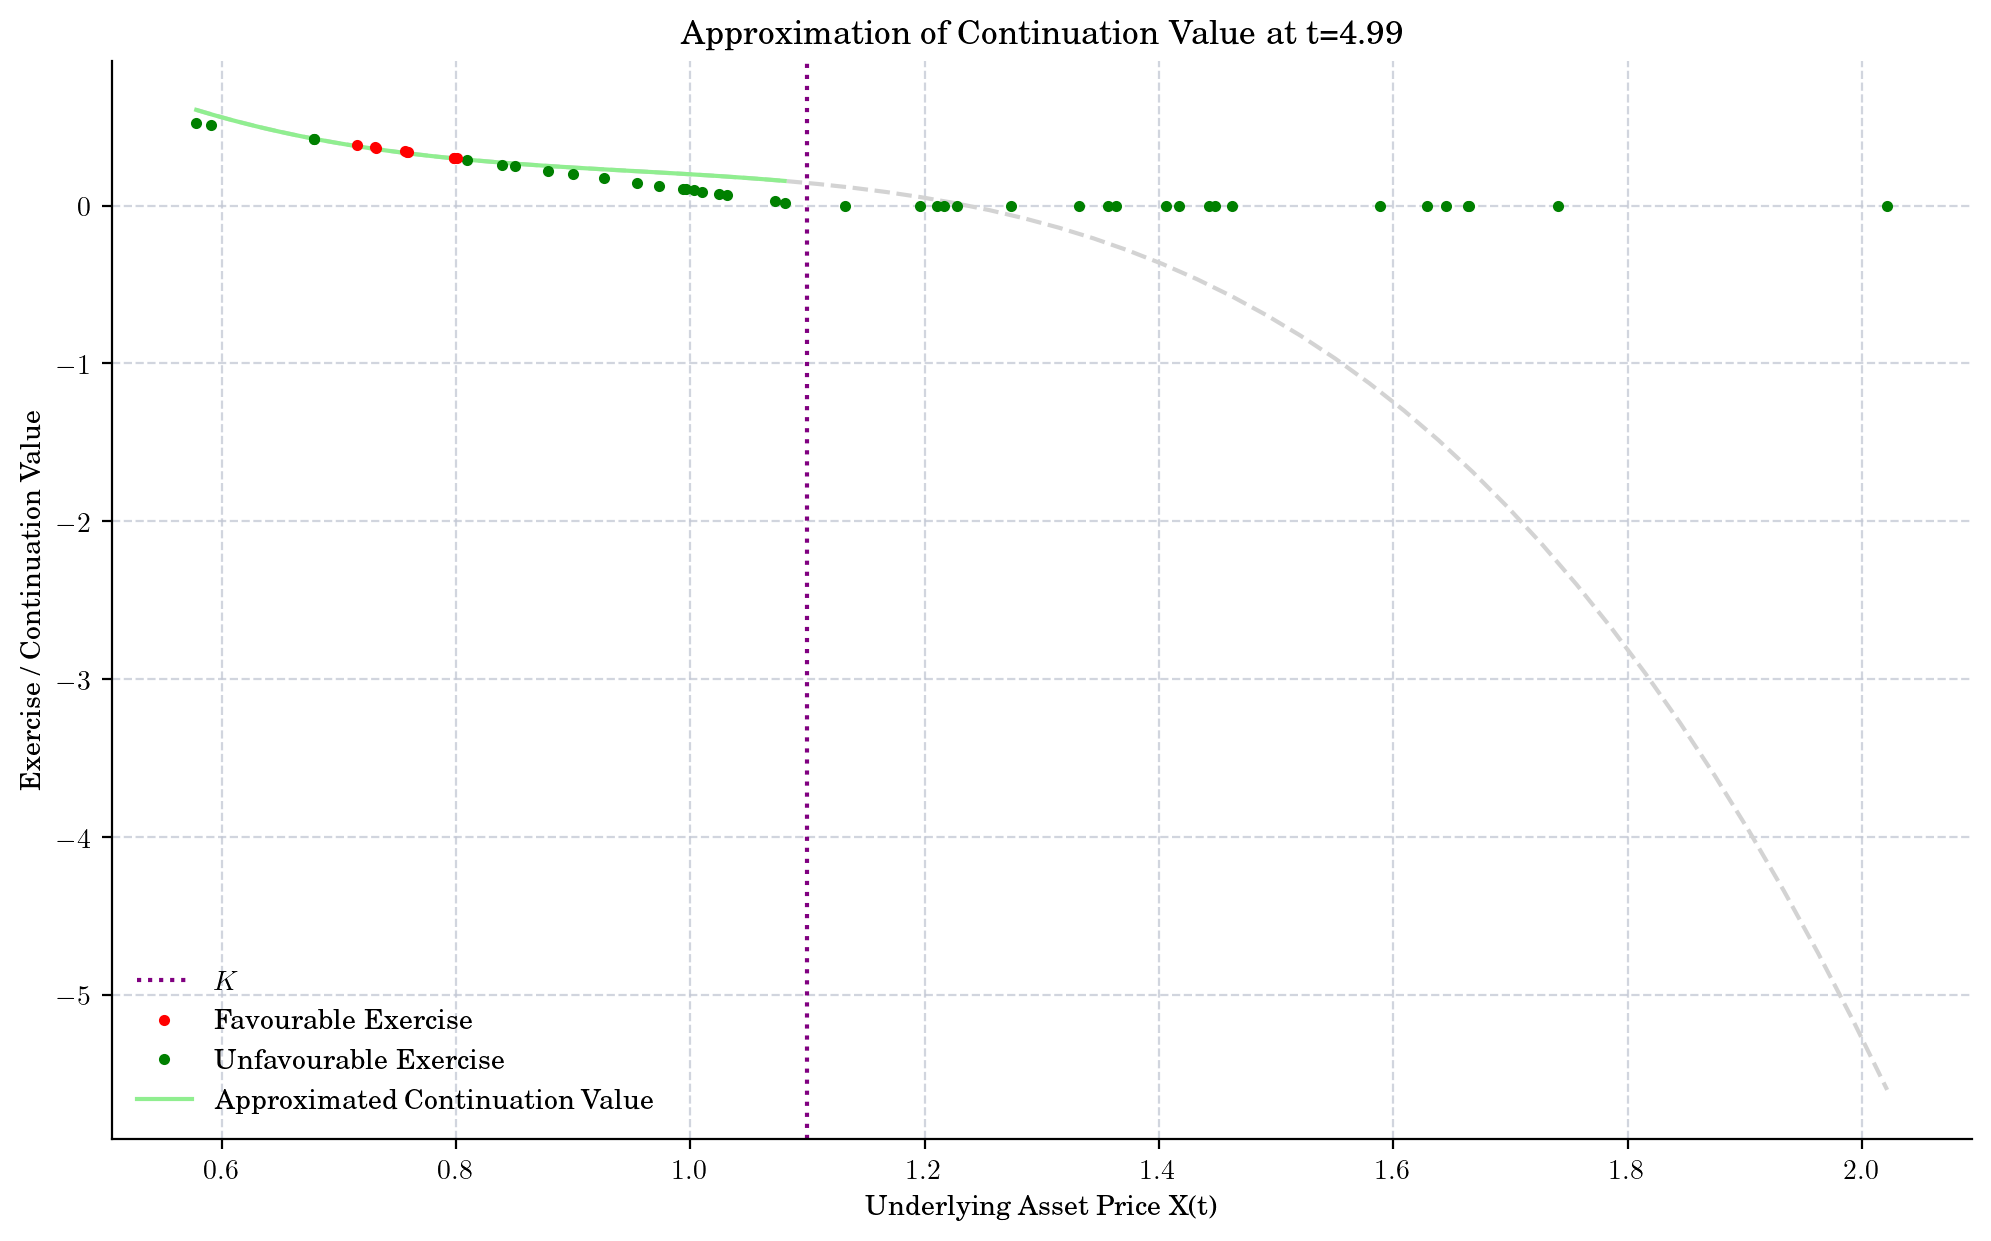

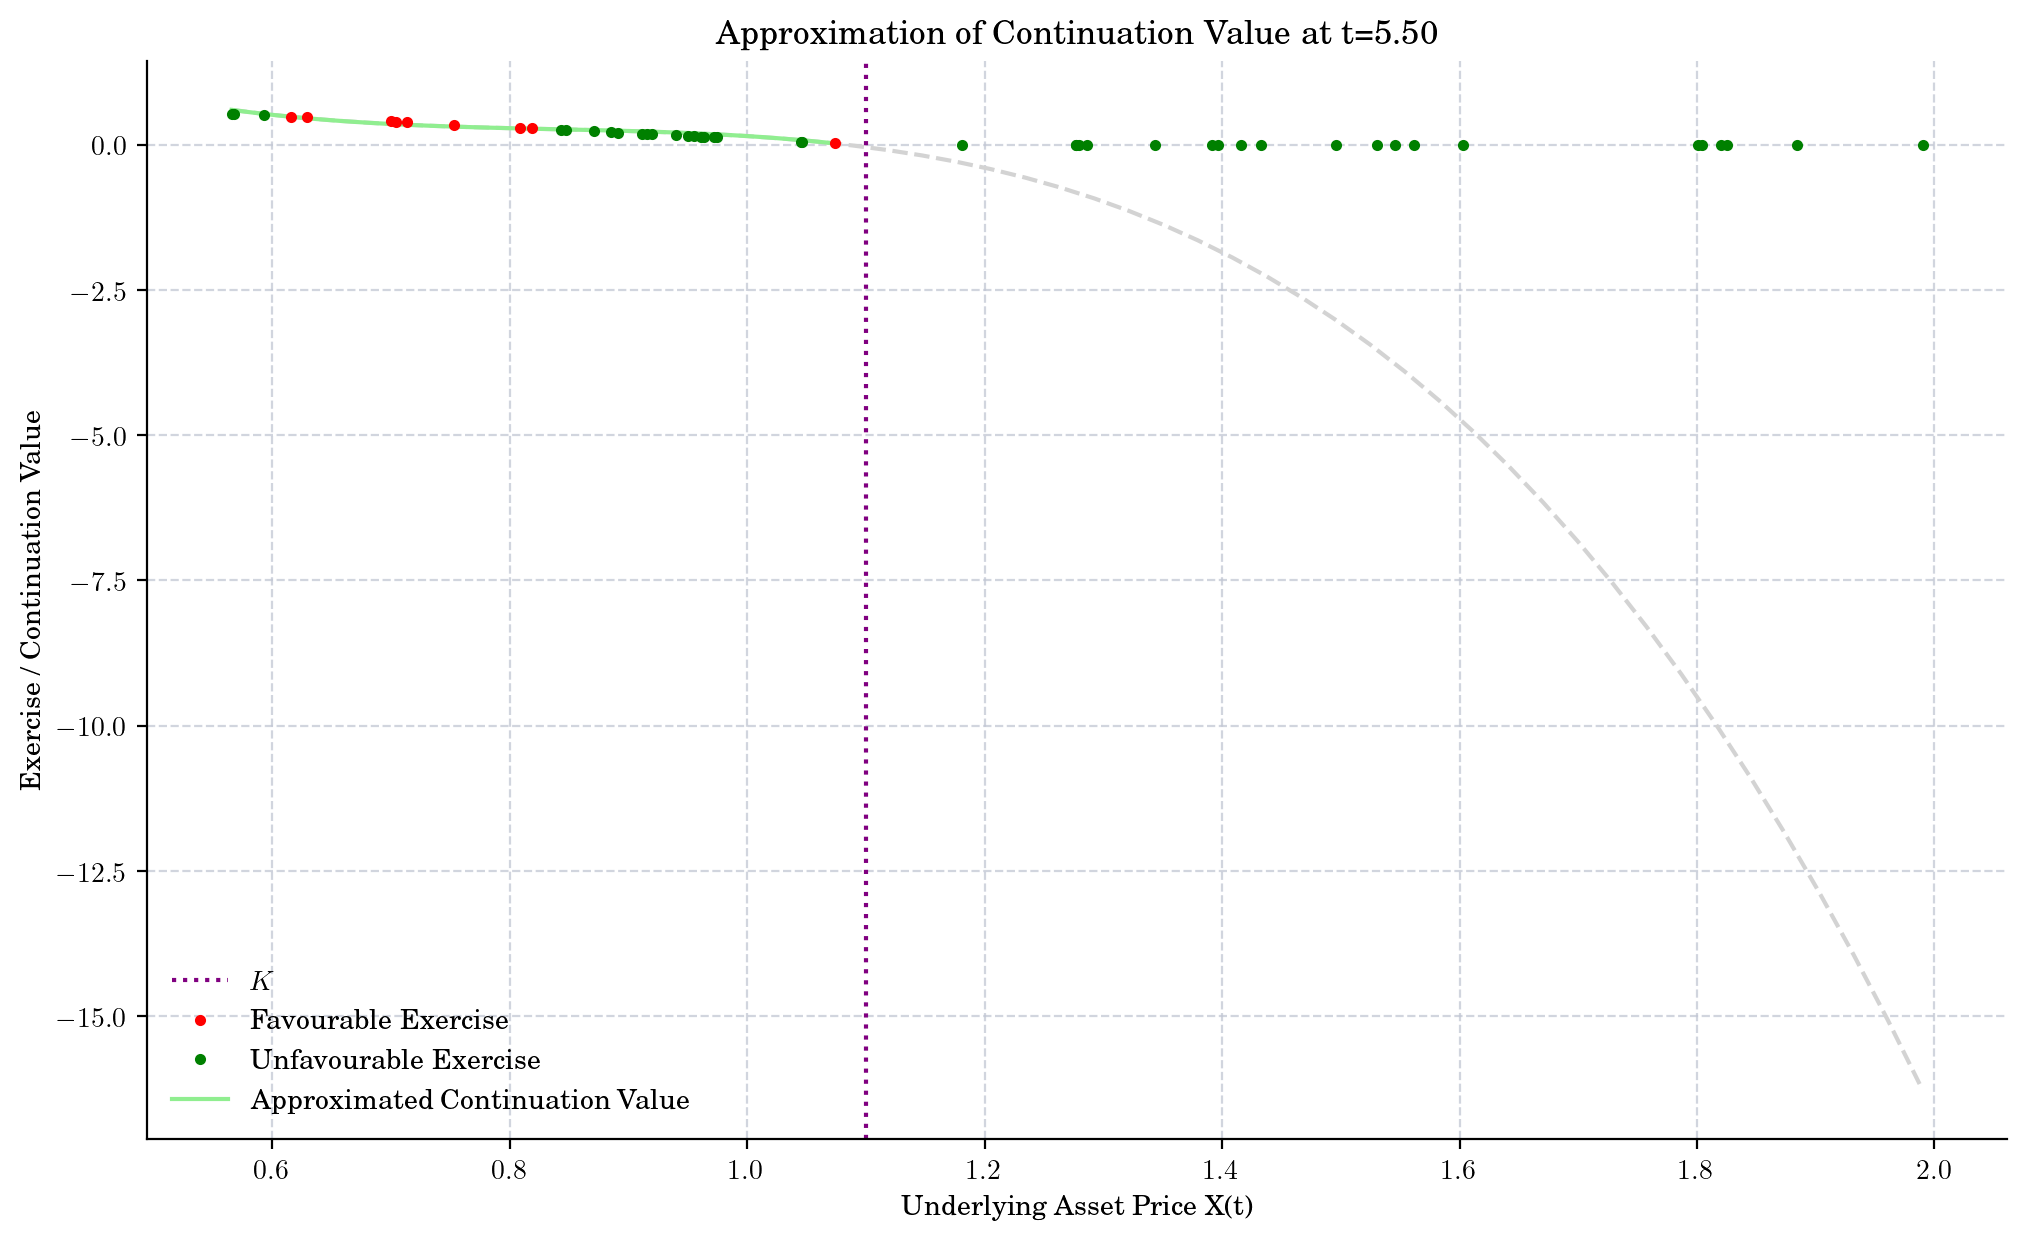

In [52]:
indices = [90, 80, 50, 20, 10]
t = times
for n, i in enumerate(indices):
    fig, ax = plt.subplots()
    plot_approx_n(i, ax)
    ax.set_title(f"Approximation of Continuation Value at t={t[-i-1]:0.2f}")
    plt.xlabel("Underlying Asset Price X(t)")
    plt.ylabel("Exercise / Continuation Value")
    plt.show()

In [53]:
exercise_times = []
exercises = []
non_exercise_times = []
non_exercises = []
for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        exercise_times.append(t[-i - 1])
        exercises.append(ex)
    for ex in x[~ex_idx]:
        non_exercise_times.append(t[-i - 1])
        non_exercises.append(ex)

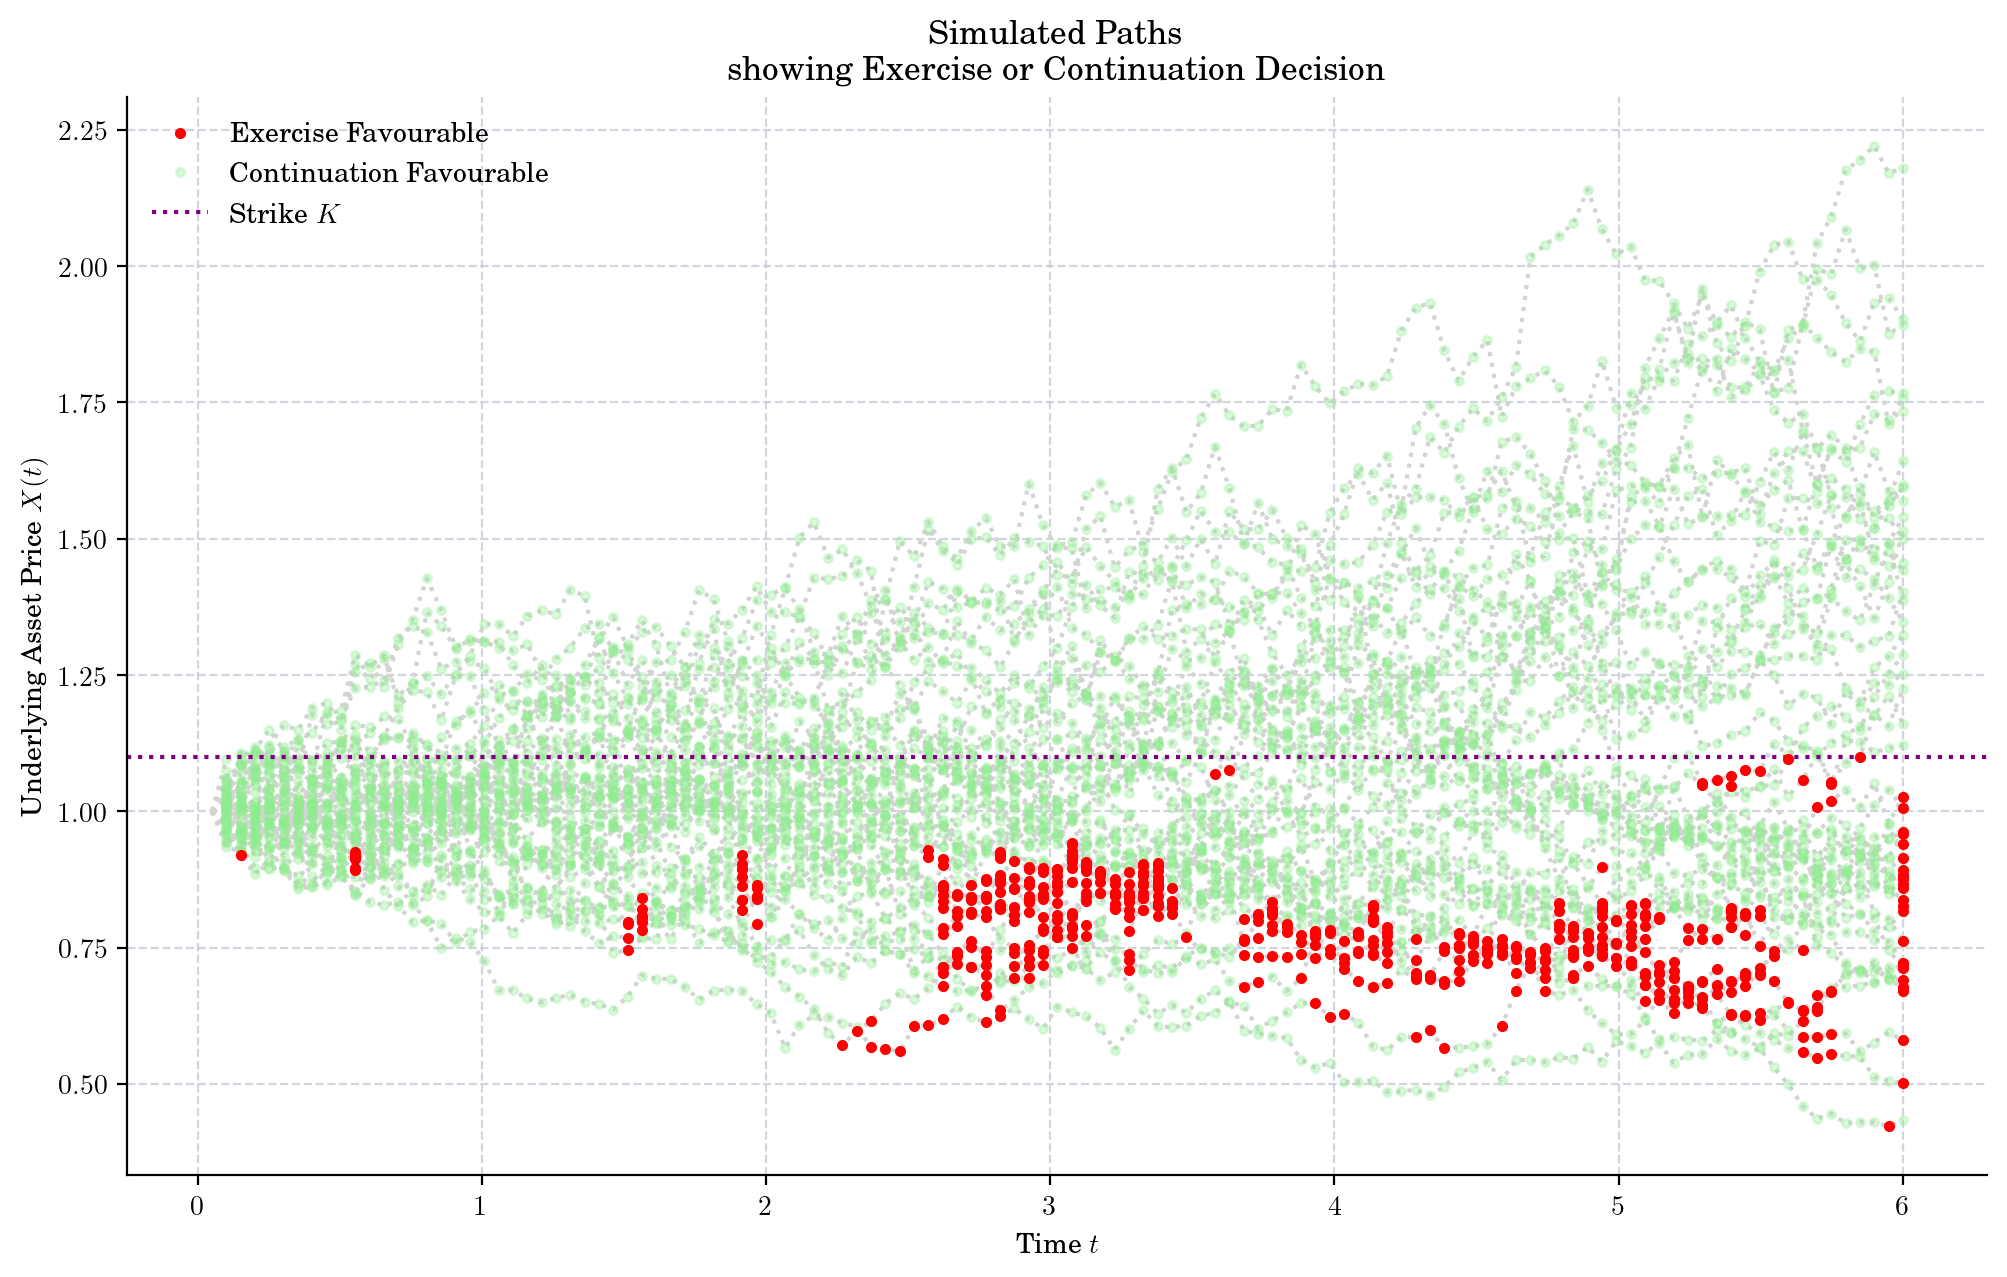

In [54]:
plt.figure()
for path in paths:
    plt.plot(times[1:], path[:-1], ':', color="lightgrey", zorder=1)
plt.plot(exercise_times, exercises, ".", color="red", label="Exercise Favourable", zorder=3)
plt.plot(non_exercise_times, non_exercises, ".", color="lightgreen", alpha=0.3, label="Continuation Favourable")
plt.axhline(y=1.1, linestyle=':', color="purple", label="Strike $K$")
plt.legend()
plt.xlabel("Time $t$")
plt.ylabel("Underlying Asset Price $X(t)$")
plt.title("Simulated Paths\n showing Exercise or Continuation Decision")
plt.show()

In [55]:
n_timesteps, n_paths = X.shape
first_exercise_idx = n_timesteps * np.ones(shape=(n_paths,), dtype="int")

for i, (cashflow, x, fitted, continuation, exercise, ex_idx) in enumerate(intermediate_results):
    for ex in x[ex_idx]:
        idx_now = (n_timesteps - i - 1) * np.ones(shape=(n_paths,), dtype="int")
        first_exercise_idx[ex_idx] = idx_now[ex_idx]

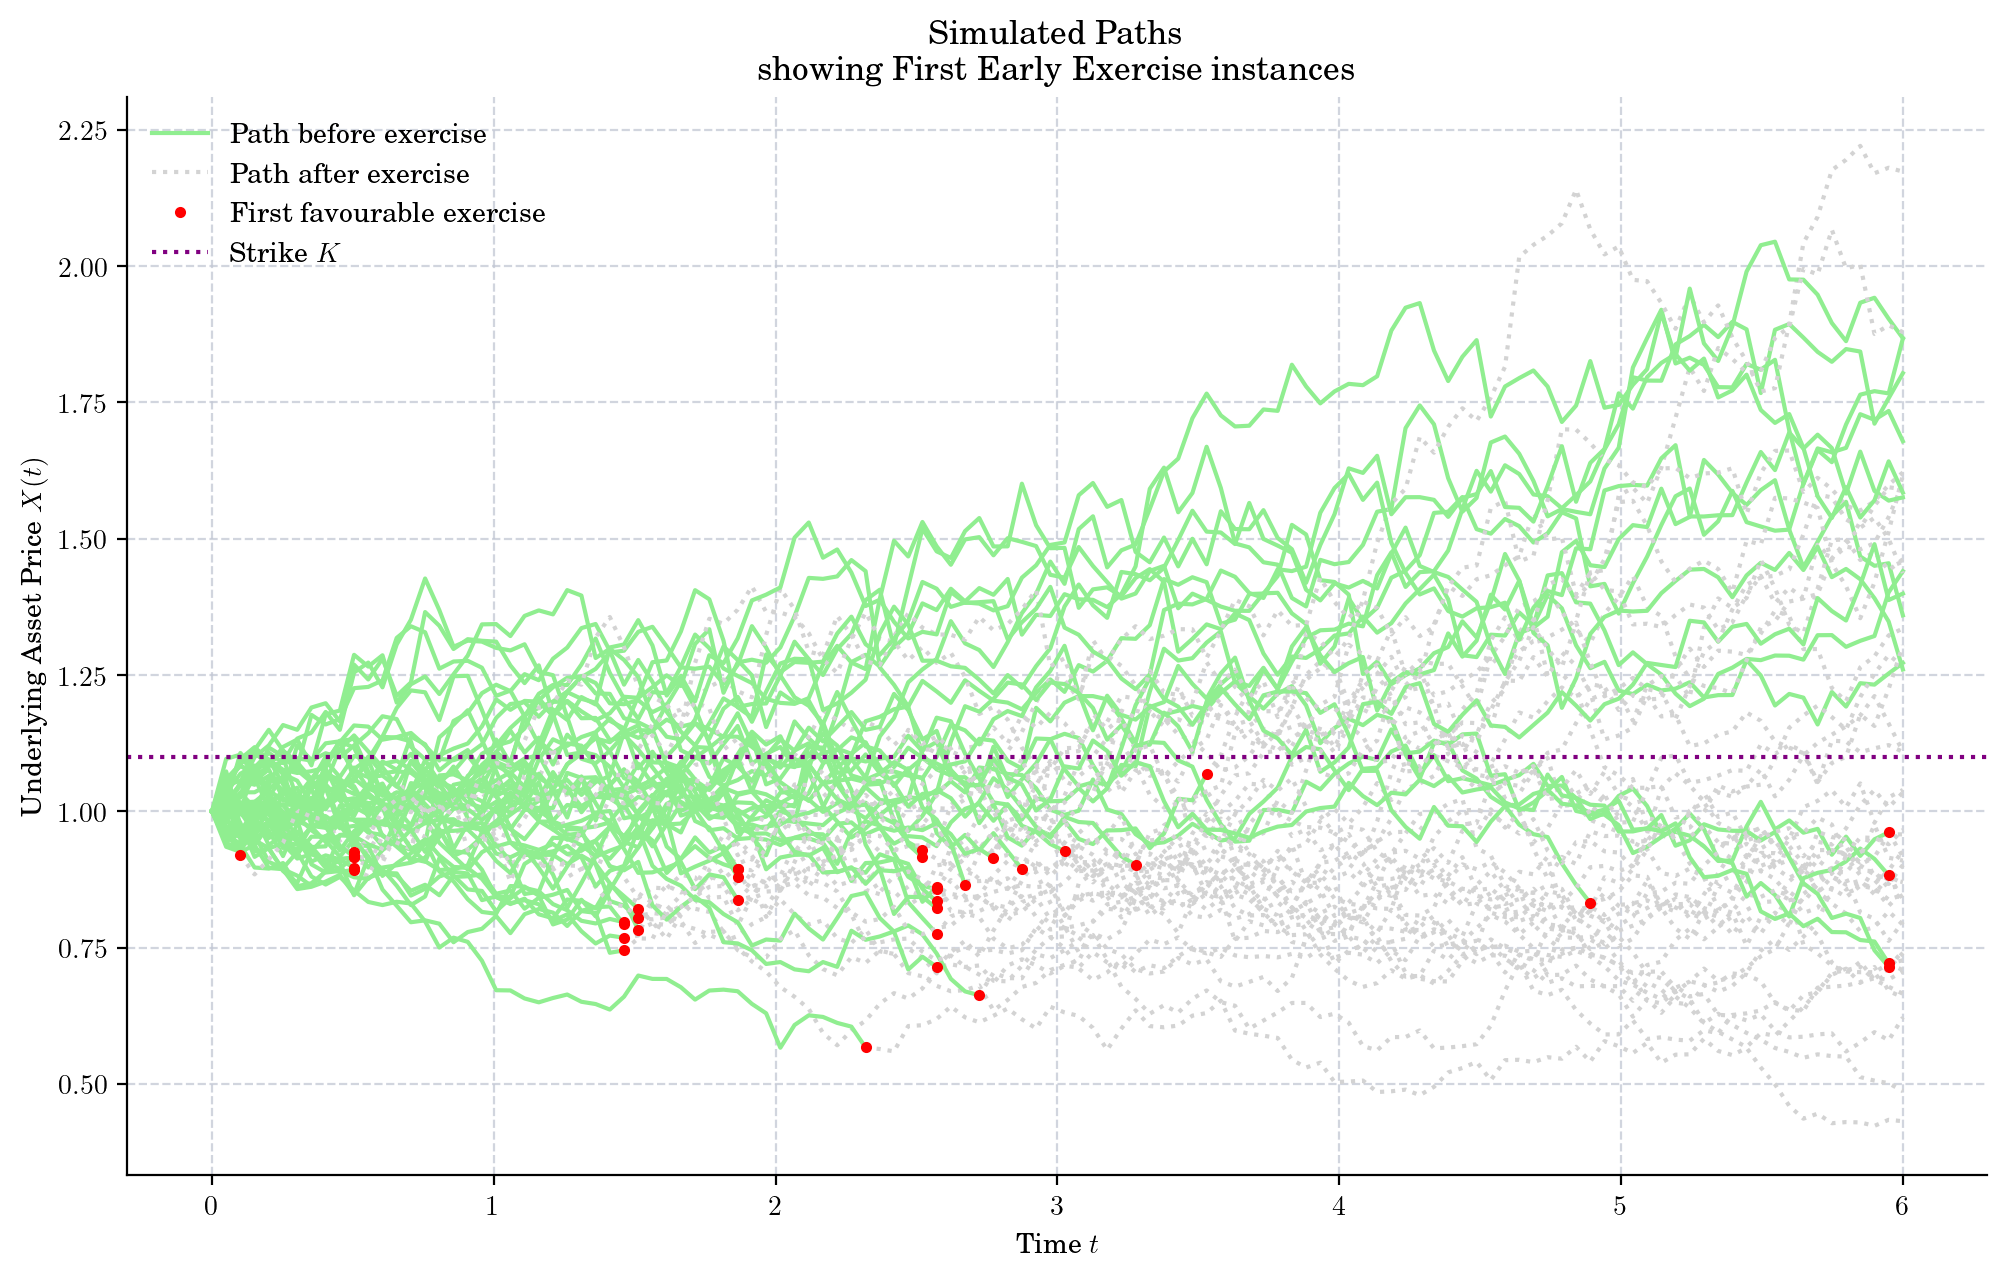

In [56]:
for idx, path in enumerate(paths):
    stop = first_exercise_idx[idx]
    (handle_path_before,) = plt.plot(times[:stop], path[:stop], color="lightgreen")
    (handle_path_stop,) = plt.plot(times[stop-1:], path[stop-1:], ':', color="lightgrey")
    if stop < len(times):
        (handle_path_after,) = plt.plot(times[stop-1], path[stop-1], 'r.', zorder=3)
        
strike_line = plt.axhline(y=K, linestyle=':', color="purple")
plt.xlabel("Time $t$")
plt.ylabel("Underlying Asset Price $X(t)$")
plt.title("Simulated Paths\n showing First Early Exercise instances")
plt.legend([handle_path_before, handle_path_stop, handle_path_after, strike_line],
    ["Path before exercise",   "Path after exercise", "First favourable exercise", "Strike $K$"])
plt.show()

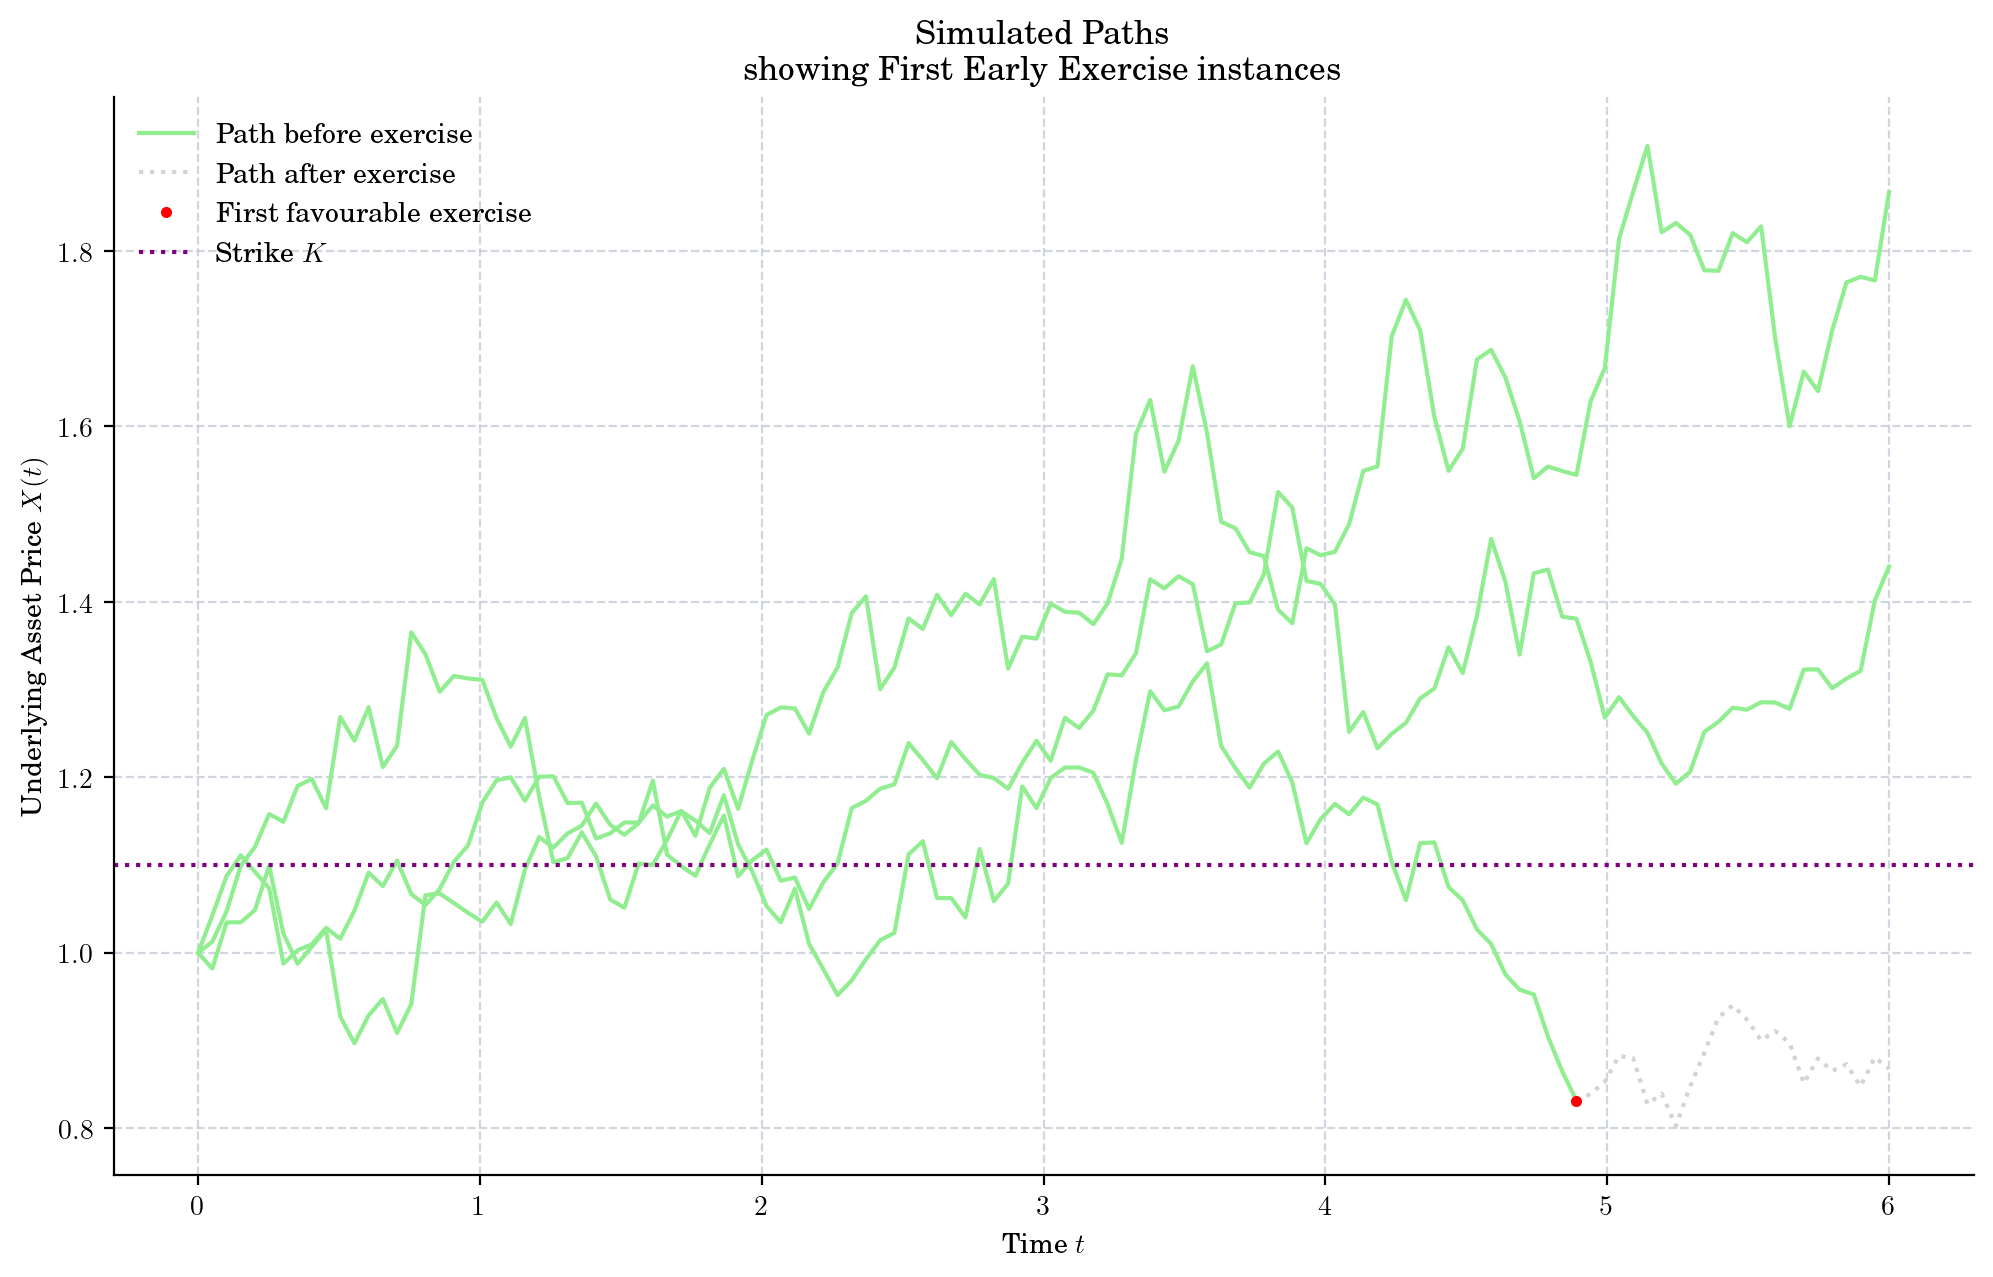

In [57]:
for idx, path in enumerate(paths[:3]):
    stop = first_exercise_idx[idx]
    (handle_path_before,) = plt.plot(times[:stop], path[:stop], color="lightgreen")
    (handle_path_stop,) = plt.plot(times[stop-1:], path[stop-1:], ':', color="lightgrey")
    if stop < len(times):
        (handle_path_after,) = plt.plot(times[stop-1], path[stop-1], 'r.', zorder=3)
        
strike_line = plt.axhline(y=K, linestyle=':', color="purple")
plt.xlabel("Time $t$")
plt.ylabel("Underlying Asset Price $X(t)$")
plt.title("Simulated Paths\n showing First Early Exercise instances")
plt.legend([handle_path_before, handle_path_stop, handle_path_after, strike_line],
    ["Path before exercise",   "Path after exercise", "First favourable exercise", "Strike $K$"])
plt.show()

In [58]:
df = np.exp(-r * (t[1] - t[0]))
american_option = cashflow * df
european_option = exercise_value(X[-1, :]) * df

In [59]:
assert np.average(american_option) >= np.average(european_option)
print(np.round(np.average(american_option), 6))
print(np.round(np.average(european_option), 6))

0.188286
0.154432
